In [2]:
import torch
import numpy as np
import os
from safetensors import safe_open

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
def get_params_safe(dir):
    # get .safetensors file
    safetensors_file = os.path.join(dir, "model.safetensors")
    with safe_open(safetensors_file, framework="pt") as f:
        params = {key: f.get_tensor(key) for key in f.keys()}

    if "qwen" in dir:
        custom_order = [
            "mlp.up_proj", "mlp.gate_proj", "mlp.down_proj",
            "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.o_proj",
            "input_layernorm", "post_attention_layernorm"
        ]
    elif "phi" in dir:
        custom_order = [
            "mlp.fc1", "mlp.fc2",
            "self_attn.q_proj", "self_attn.k_proj", "self_attn.v_proj", "self_attn.dense",
            "input_layernorm",
        ]

    def sort_key(key):
        if "lm_head" in key: return 9999, 9999
        if key == 'model.embed_tokens.weight': return -1, -1 # for Qwen
        if key == 'model.norm.weight': return 9998, 9998 # for Qwen
        if 'model.final_layernorm' in key: return 9998, 9998 # for Phi
        layer = int(key.split('.')[2])
        component = ".".join(key.split('.')[3:])
        return layer, next((i for i, c in enumerate(custom_order) if c in component), len(custom_order))

    params = dict(sorted(params.items(), key=lambda x: sort_key(x[0])))
    return params

def get_param_diff_norm(og_params, ft_params):
    param_diff = {}
    for param_name in og_params.keys():
        diff = og_params[param_name] - ft_params[param_name]
        norm = torch.linalg.norm(diff)
        # norm = torch.abs(diff).mean()
        param_diff[param_name] = norm.item()
    return param_diff

In [4]:
def plot_layer_comparisons(base_model, models, titles, vminmax=(None,None), in_scope=None, out_scope=['bias'], save_name=None, **kwargs):
    """
    Plots the MLP delta norm heatmaps for an arbitrary number of models compared to a base model.

    Parameters:
    - base_model: The base model to compare against.
    - models: A list of models to compare.
    - titles: A list of titles for each subplot, corresponding to the models.
    """
    params_base = get_params_safe(base_model)

    # Get the deltas for all models compared to the base model
    def get_delta(model):
        params_model = get_params_safe(model)
        delta = get_param_diff_norm(params_base, params_model)
        delta = list(delta.items())

        # Filter only certain layers with
        if in_scope:
            delta = [(k, v) for k, v in delta if any([scope in k for scope in in_scope])]
        if out_scope:
            delta = [(k, v) for k, v in delta if all([scope not in k for scope in out_scope])]
        return delta

    # Extract layer information from parameter names
    def extract_layer_info(param_name):
        if "layers." in param_name:
            layer_num = param_name.split(".")[2]  # Assumes format 'model.layers.n...'
            return int(layer_num)
        return -1  # Return -1 for non-layer parameters

    # Function to prepare data for heatmap plotting
    def prepare_heatmap_data(param_group):
        param_names = [item[0] for item in param_group]
        delta_norms = [item[1] for item in param_group]
        layer_numbers = [extract_layer_info(param) for param in param_names]

        # Group by layer numbers and add gaps between layers
        gap = 1  # Define gap size between layers
        grouped_delta_norms = []
        current_layer = layer_numbers[0]

        for i, param_name in enumerate(param_names):
            layer = layer_numbers[i]

            if layer != current_layer:
                grouped_delta_norms.extend([np.nan] * gap)  # Add gap
                current_layer = layer

            grouped_delta_norms.append(delta_norms[i])

        # Get unique layers for x-ticks
        unique_layers = sorted(set(layer_numbers))
        layer_positions = []
        current_pos = 0

        for layer in unique_layers:
            count_in_layer = layer_numbers.count(layer)
            mid_pos = current_pos + (count_in_layer - 1) / 2
            layer_positions.append(mid_pos)  # Position the tick in the middle of the group
            current_pos += count_in_layer + gap

        return grouped_delta_norms, unique_layers, layer_positions

    # Prepare the data for each model
    mlp_data_list = []
    for model in models:
        mlp_data, mlp_layers, mlp_layer_positions = prepare_heatmap_data(get_delta(model))
        mlp_data_list.append((mlp_data, mlp_layers, mlp_layer_positions))

    # Create subplots dynamically based on the number of models
    if len(models) == 1:
        fig, axes = plt.subplots(1, 1, figsize=(14, 2), sharex=True)
    else:
        fig, axes = plt.subplots(len(models), 1, figsize=(14, len(models) * 2), sharex=True, dpi=300)

    # Ensure axes is always a list (it becomes a single object if there's only one model)
    if len(models) == 1:
        axes = [axes]

    # Plot each model's heatmap in its subplot
    for i, (mlp_data, mlp_layers, mlp_layer_positions) in enumerate(mlp_data_list):
        sns.heatmap(np.array([mlp_data]), annot=False, cmap='viridis', cbar=True, yticklabels=[f"Delta Norms"], ax=axes[i], **kwargs)
        axes[i].set_xticks(mlp_layer_positions)
        if "embed" in in_scope:
            labels = ['Embed']
            labels.extend([f'Layer {layer}' for layer in mlp_layers][1:])
            axes[i].set_xticklabels(labels, rotation=90)
        else:
            labels = [f'Layer {layer}' for layer in mlp_layers]
            axes[i].set_xticklabels(labels, rotation=90)
        axes[i].set_title(titles[i])

    if save_name:
        fig.savefig(save_name, format='svg', bbox_inches='tight')

    # Adjust layout to prevent overlap
    plt.tight_layout()
    plt.show()

In [5]:
def plot_heatmaps(params1, params2, save=None):
    delta = get_param_diff_norm(params1, params2)
    delta = list(delta.items())

    delta_plot = delta
    delta_plot = [(k, v) for k, v in delta_plot if "mlp." in k or "attn." in k]
    delta_plot = [(k, v) for k, v in delta_plot if ".weight" in k]

    # Extract layer information from parameter names
    def extract_layer_info(param_name):
        if "layers." in param_name:
            layer_num = param_name.split(".")[2]  # Assumes format 'model.layers.n...'
            return int(layer_num)
        return -1  # Return -1 for non-layer parameters

    # Separate parameters into MLP and Attention groups
    mlp_params = [(param, norm) for param, norm in delta_plot if "mlp." in param]
    attn_params = [(param, norm) for param, norm in delta_plot if "attn." in param]

    # Function to prepare data for heatmap plotting
    def prepare_heatmap_data(param_group):
        param_names = [item[0] for item in param_group]
        delta_norms = [item[1] for item in param_group]
        layer_numbers = [extract_layer_info(param) for param in param_names]

        # Group by layer numbers and add gaps between layers
        gap = 1  # Define gap size between layers
        grouped_delta_norms = []
        current_layer = layer_numbers[0]

        for i, param_name in enumerate(param_names):
            layer = layer_numbers[i]

            if layer != current_layer:
                grouped_delta_norms.extend([np.nan] * gap)  # Add gap
                current_layer = layer

            grouped_delta_norms.append(delta_norms[i])

        # Get unique layers for x-ticks
        unique_layers = sorted(set(layer_numbers))
        layer_positions = []
        current_pos = 0

        for layer in unique_layers:
            count_in_layer = layer_numbers.count(layer)
            mid_pos = current_pos + (count_in_layer - 1) / 2
            layer_positions.append(mid_pos)  # Position the tick in the middle of the group
            current_pos += count_in_layer + gap

        return grouped_delta_norms, unique_layers, layer_positions

    # Prepare data for both subfigures
    mlp_data, mlp_layers, mlp_layer_positions = prepare_heatmap_data(mlp_params)
    attn_data, attn_layers, attn_layer_positions = prepare_heatmap_data(attn_params)

    # Create subplots
    fig, axes = plt.subplots(2, 1, figsize=(14, 6))

    # Plot MLP heatmap
    sns.heatmap(np.array([mlp_data]), annot=False, cmap='viridis', cbar=True, yticklabels=["Delta Norms"], ax=axes[0], vmin=0.4, vmax=1.2)
    axes[0].set_xticks(mlp_layer_positions)
    axes[0].set_xticklabels([f'Layer {layer}' for layer in mlp_layers], rotation=90)
    axes[0].set_title("MLP Layers")

    # Plot Attention heatmap
    sns.heatmap(np.array([attn_data]), annot=False, cmap='viridis', cbar=True, yticklabels=["Delta Norms"], ax=axes[1], vmin=0, vmax=0.5)
    axes[1].set_xticks(attn_layer_positions)
    axes[1].set_xticklabels([f'Layer {layer}' for layer in attn_layers], rotation=90)
    axes[1].set_title("Attention Layers")

    # Adjust layout
    plt.tight_layout()
    plt.show()

    if save:
        # tight layout
        fig.savefig(save, format='svg', bbox_inches='tight')


## General Heatmaps

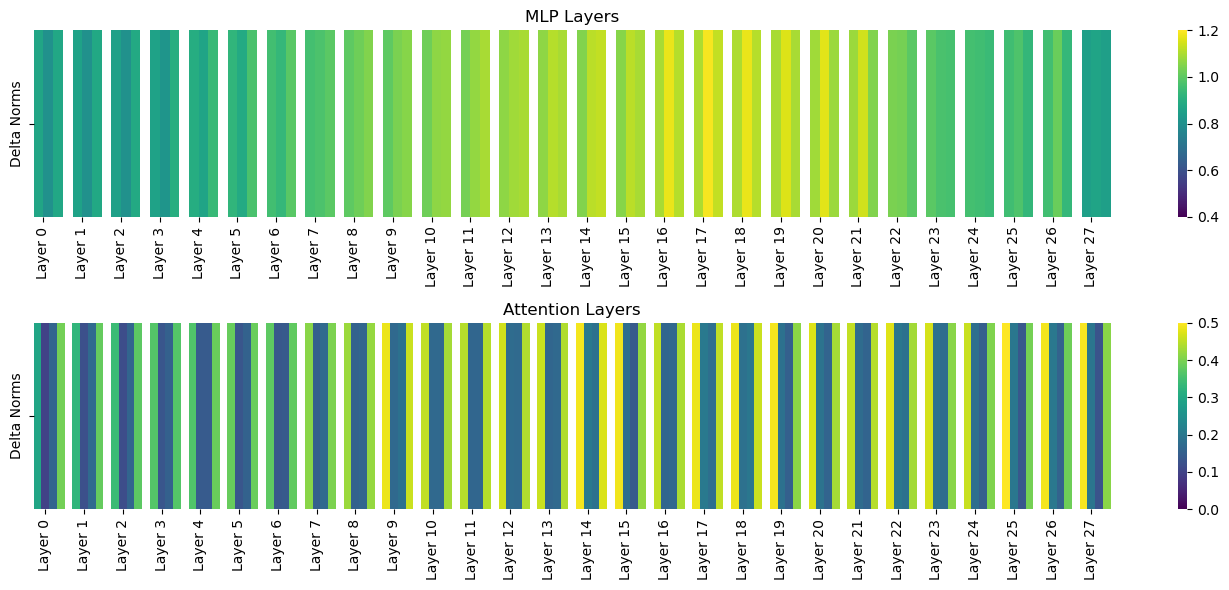

In [22]:
plot_heatmaps(
    get_params_safe("models/qwen2-1.5b"),
    get_params_safe("models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250"),
    # save="figures/PD_qwen_tofu_mlp_attn.svg"
)

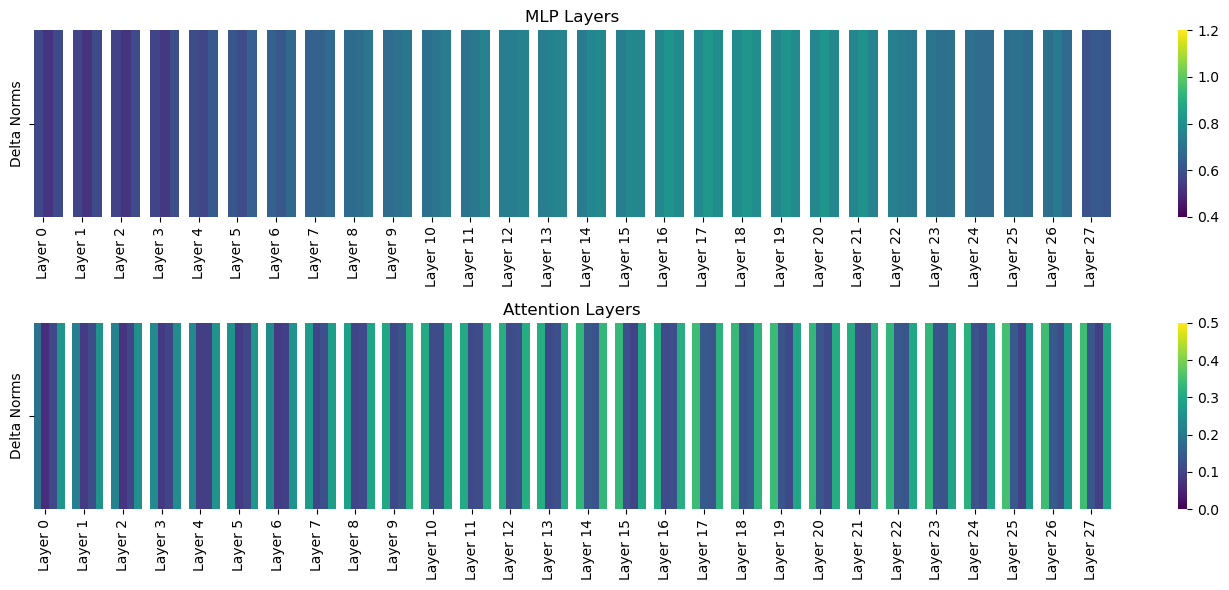

In [54]:
plot_heatmaps(
    get_params_safe("models/qwen2-1.5b"),
    get_params_safe("models/qwen2-1.5b_ft_tofu-1600_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-500")
)

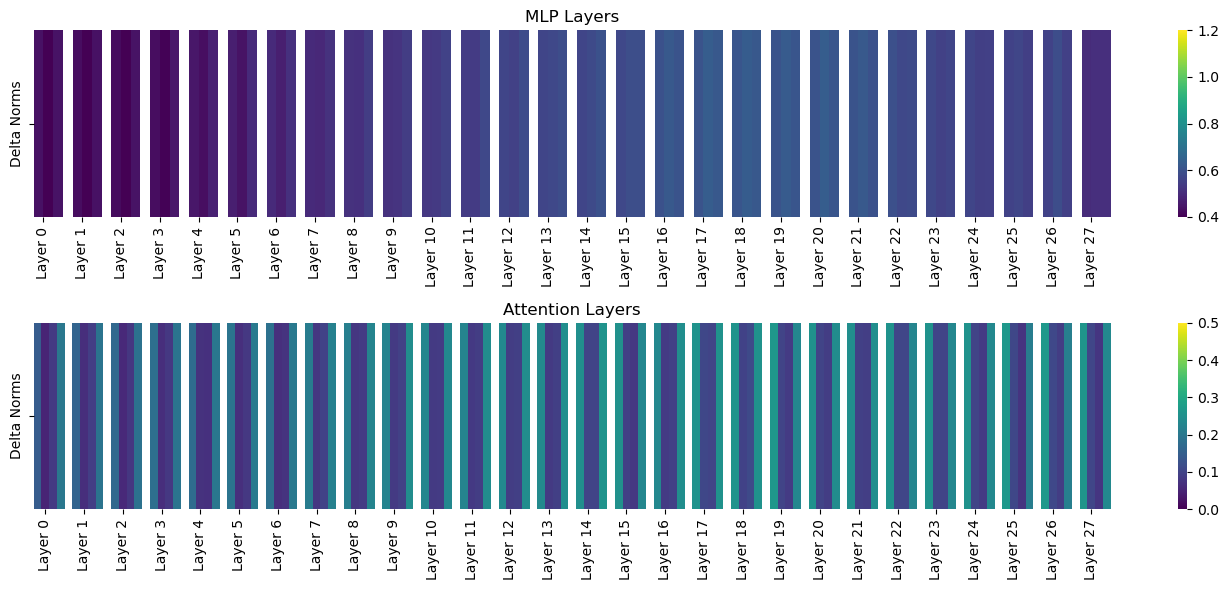

In [55]:
plot_heatmaps(
    get_params_safe("models/qwen2-1.5b"),
    get_params_safe("models/qwen2-1.5b_ft_tofu-800_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-250")
)

## Layer comparison heatmaps

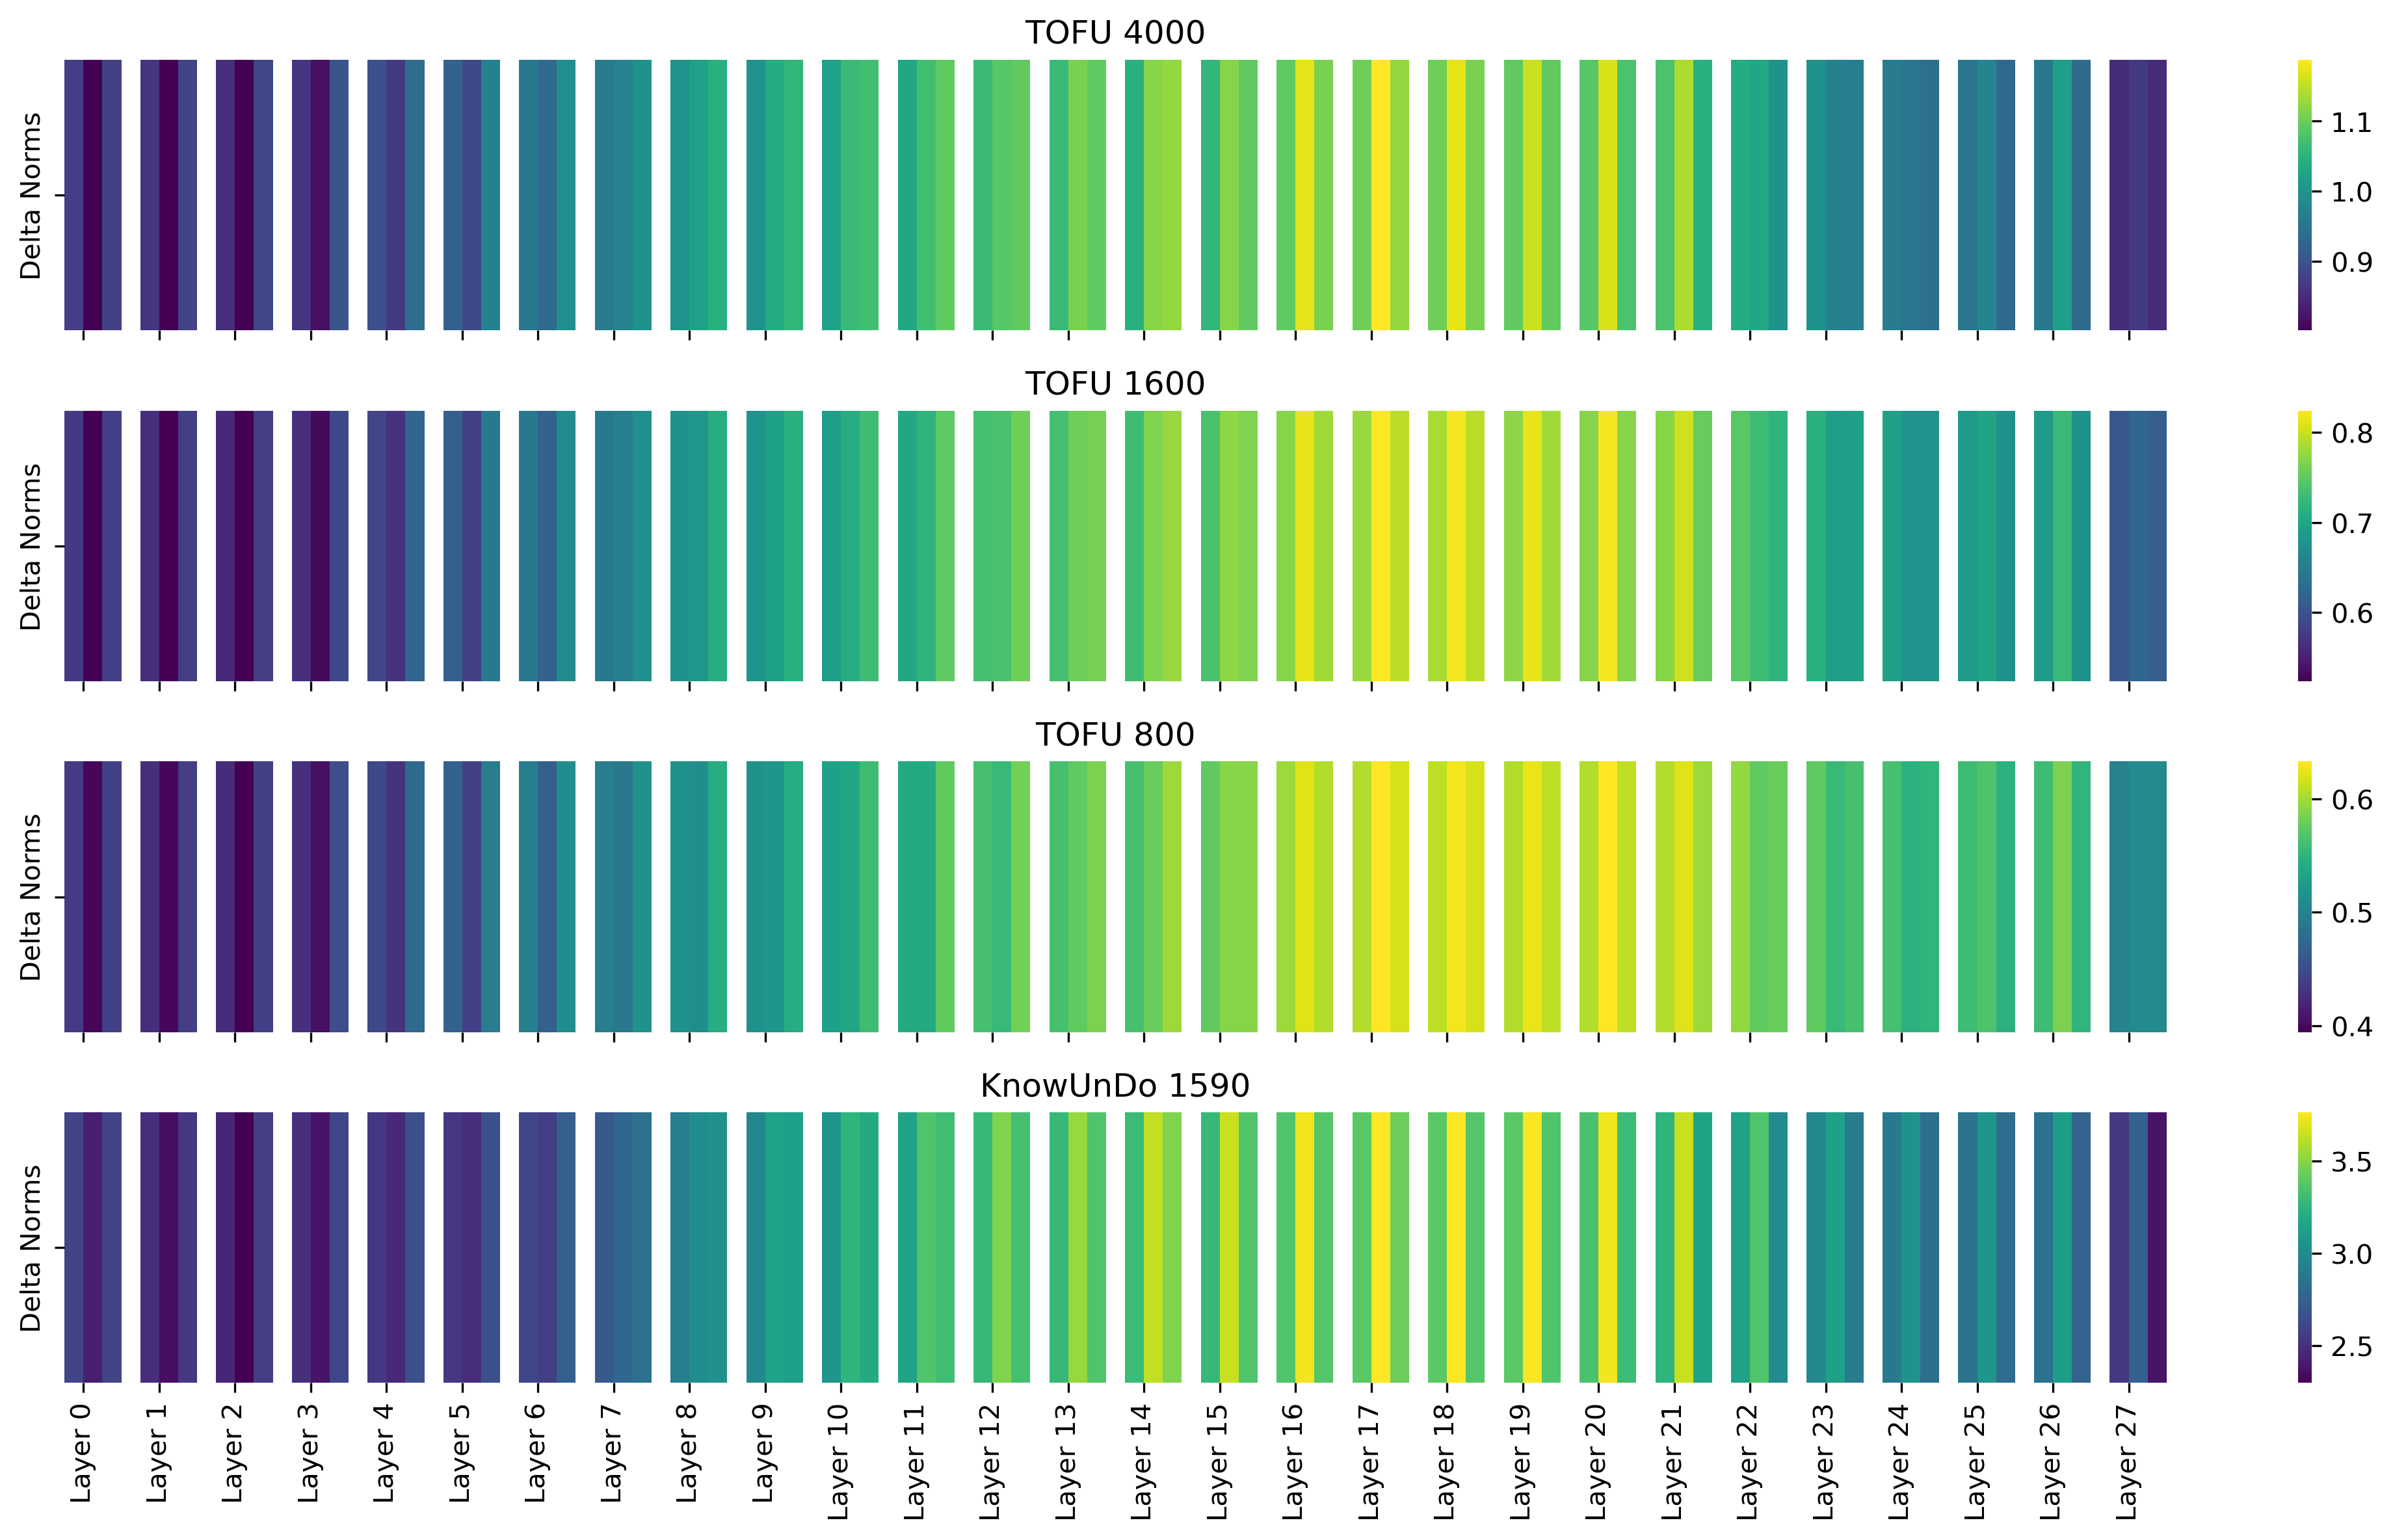

In [238]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b",
    models=[
        "models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
        "models/qwen2-1.5b_ft_tofu-1600_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-500",
        "models/qwen2-1.5b_ft_tofu-800_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-250",
        "models/qwen2-1.5b_ft_knowundo-copyright_noLORA_epochs10_lr1e-04_wd0.01_full_seed42/checkpoint-496"
        ],
    titles=["TOFU 4000", "TOFU 1600", "TOFU 800", "KnowUnDo 1590"],
    in_scope=[
        # "embed",
        "mlp",
        # "attn",
        # "norm",
    ],
    # out_scope=None,
)

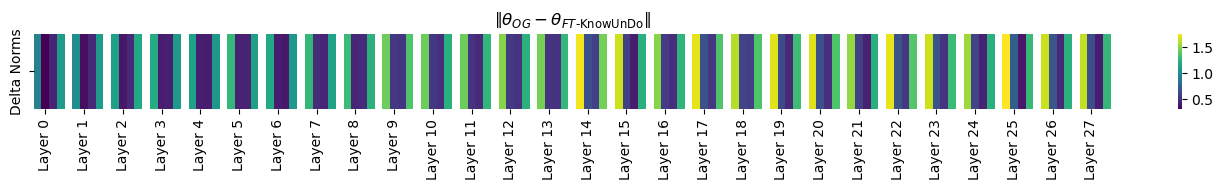

In [9]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b",
    models=[
        "models/qwen2-1.5b_ft_knowundo-copyright_noLORA_epochs10_lr1e-04_wd0.01_full_seed42/checkpoint-496"
        ],
    titles=[
        r"$\left\Vert\theta_{OG} - \theta_{FT\text{-KnowUnDo}}\right\Vert$",
    ],
    in_scope=[
        # "embed",
        # "mlp",
        "attn",
        # "norm",
    ],
    # out_scope=None,
    # save_name="figures/PD_qwen_knowundo_ft_mlp.svg"
)

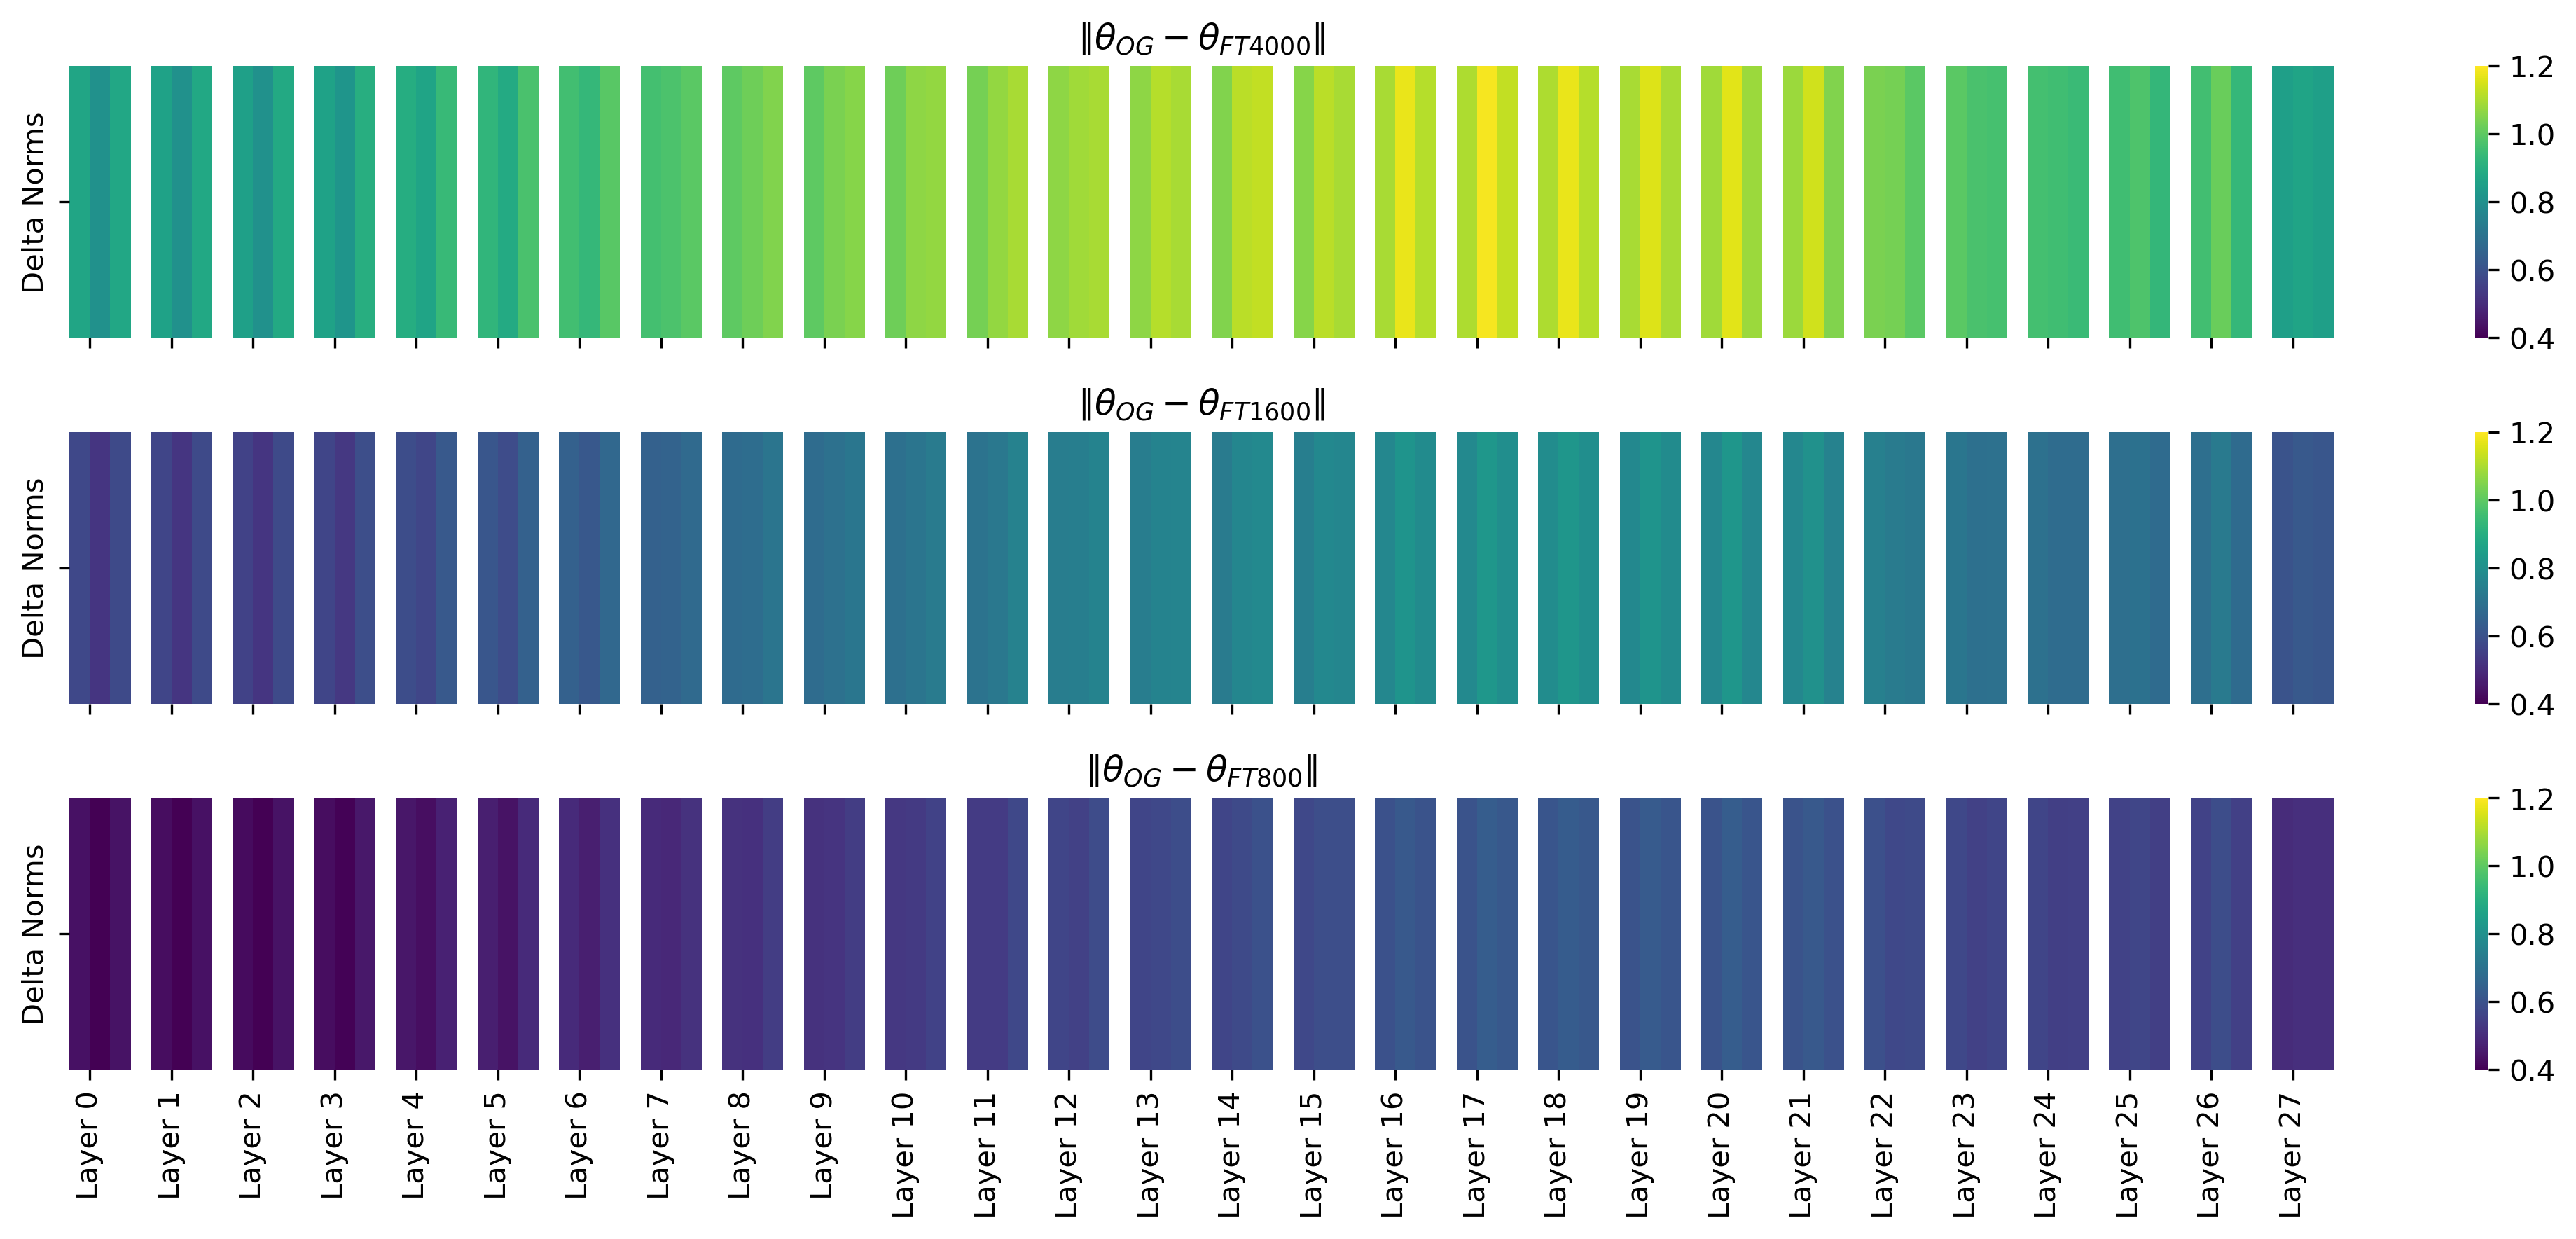

In [49]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b",
    models=[
        "models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
        "models/qwen2-1.5b_ft_tofu-1600_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-500",
        "models/qwen2-1.5b_ft_tofu-800_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-250",
        ],
    titles=[r"$\left\Vert\theta_{OG} - \theta_{FT4000}\right\Vert$", r"$\left\Vert\theta_{OG} - \theta_{FT1600}\right\Vert$", r"$\left\Vert\theta_{OG} - \theta_{FT800}\right\Vert$"],
    in_scope=[
        # "embed",
        "mlp",
        # "attn",
        # "norm",
    ],
    # out_scope=None,
    vmin=0.4, vmax=1.2,
    # save_name="figures/PD_qwen_tofu_num_ft_mlp.svg"
)

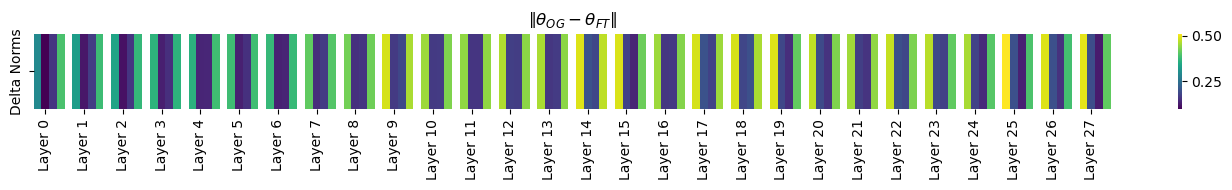

In [12]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b",
    models=[
        # "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_retain99_seed42/checkpoint-1237",
        "models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
        # "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_so-influence_k0.1+0_3e-05_forget01_8_to-examine/checkpoint-18",
        ],
    # titles=["TOFU (Retain)", "TOFU 4000", "TOFU 4000 (Unlearned)"],
    titles=[
        # r"$\left\Vert\theta_{OG} - \theta_{RT}\right\Vert$",
        r"$\left\Vert\theta_{OG} - \theta_{FT}\right\Vert$",
        # r"$\left\Vert\theta_{OG} - \theta_{UL}\right\Vert$"
    ],
    in_scope=[
        # "embed",
        # "mlp",
        "attn",
        # "layernorm",
        # "norm",
    ],
    # out_scope=None,
    # vmin=0.4,
    # vmax=1.2
    # save_name="figures/PD_qwen_tofu_ft_embed.svg"
    # save_name="figures/PD_qwen_tofu_rt_embed.svg"
)

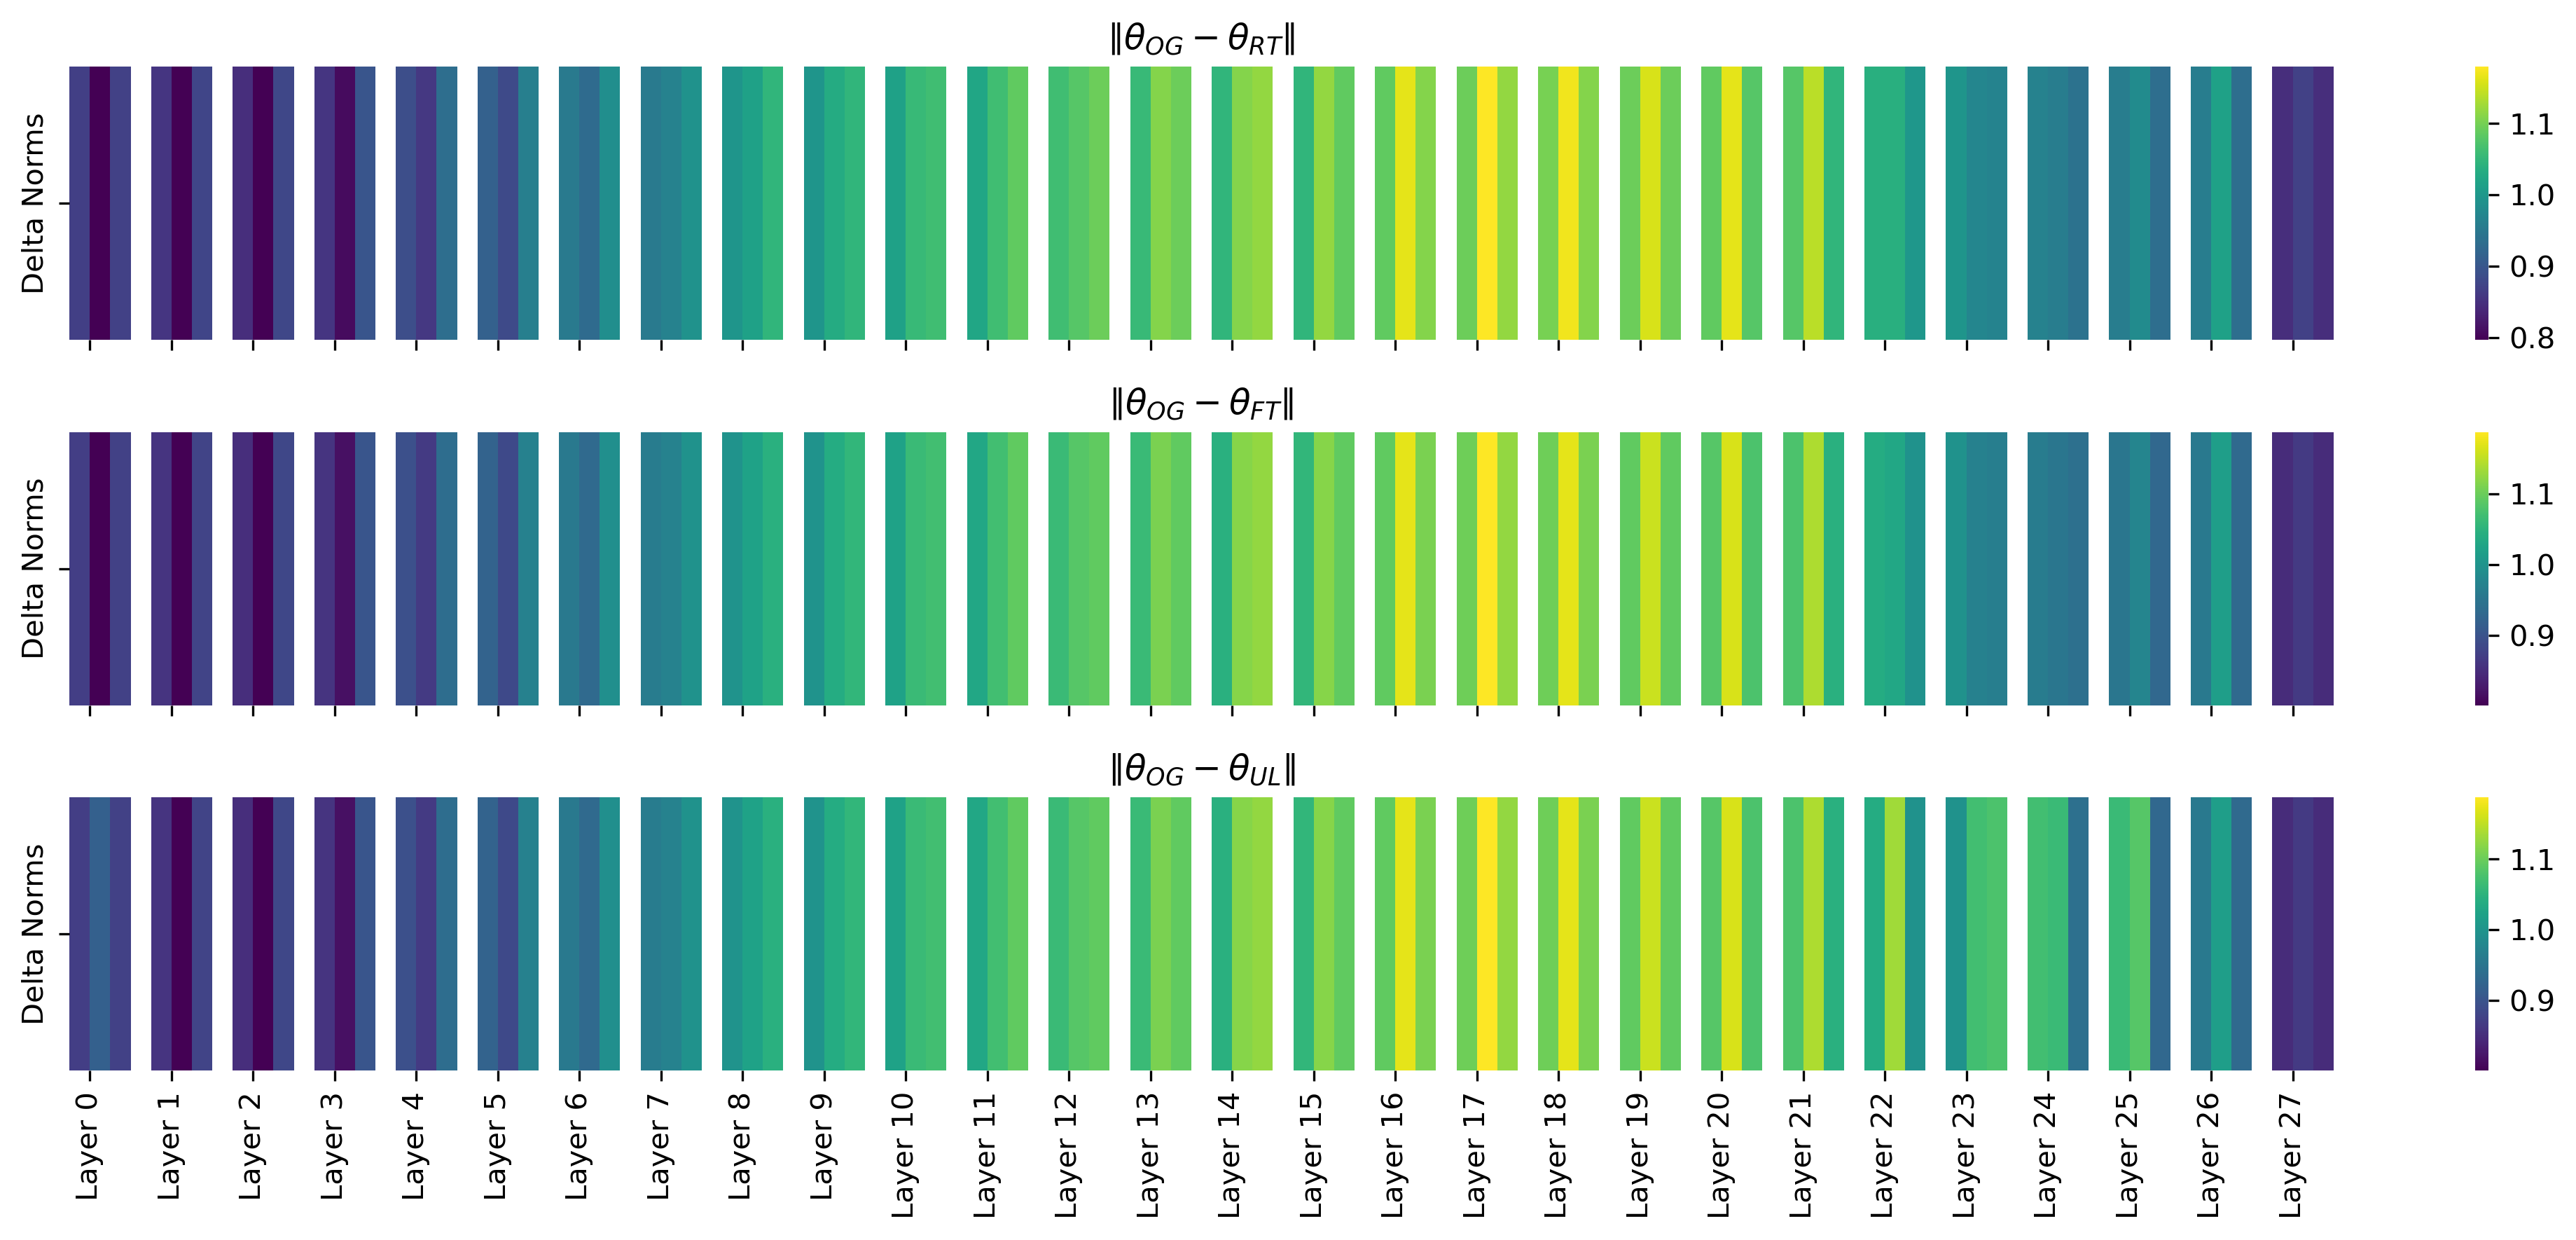

In [229]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b",
    models=[
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_retain99_seed42/checkpoint-1237",
        "models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_so-influence_k0.1+0_3e-05_forget01_8_to-examine/checkpoint-18",
        ],
    # titles=["TOFU (Retain)", "TOFU 4000", "TOFU 4000 (Unlearned)"],
    titles=[r"$\left\Vert\theta_{OG} - \theta_{RT}\right\Vert$", r"$\left\Vert\theta_{OG} - \theta_{FT}\right\Vert$", r"$\left\Vert\theta_{OG} - \theta_{UL}\right\Vert$"],
    in_scope=[
        # "embed",
        "mlp",
        # "attn",
        # "norm",
    ],
    # out_scope=None,
)

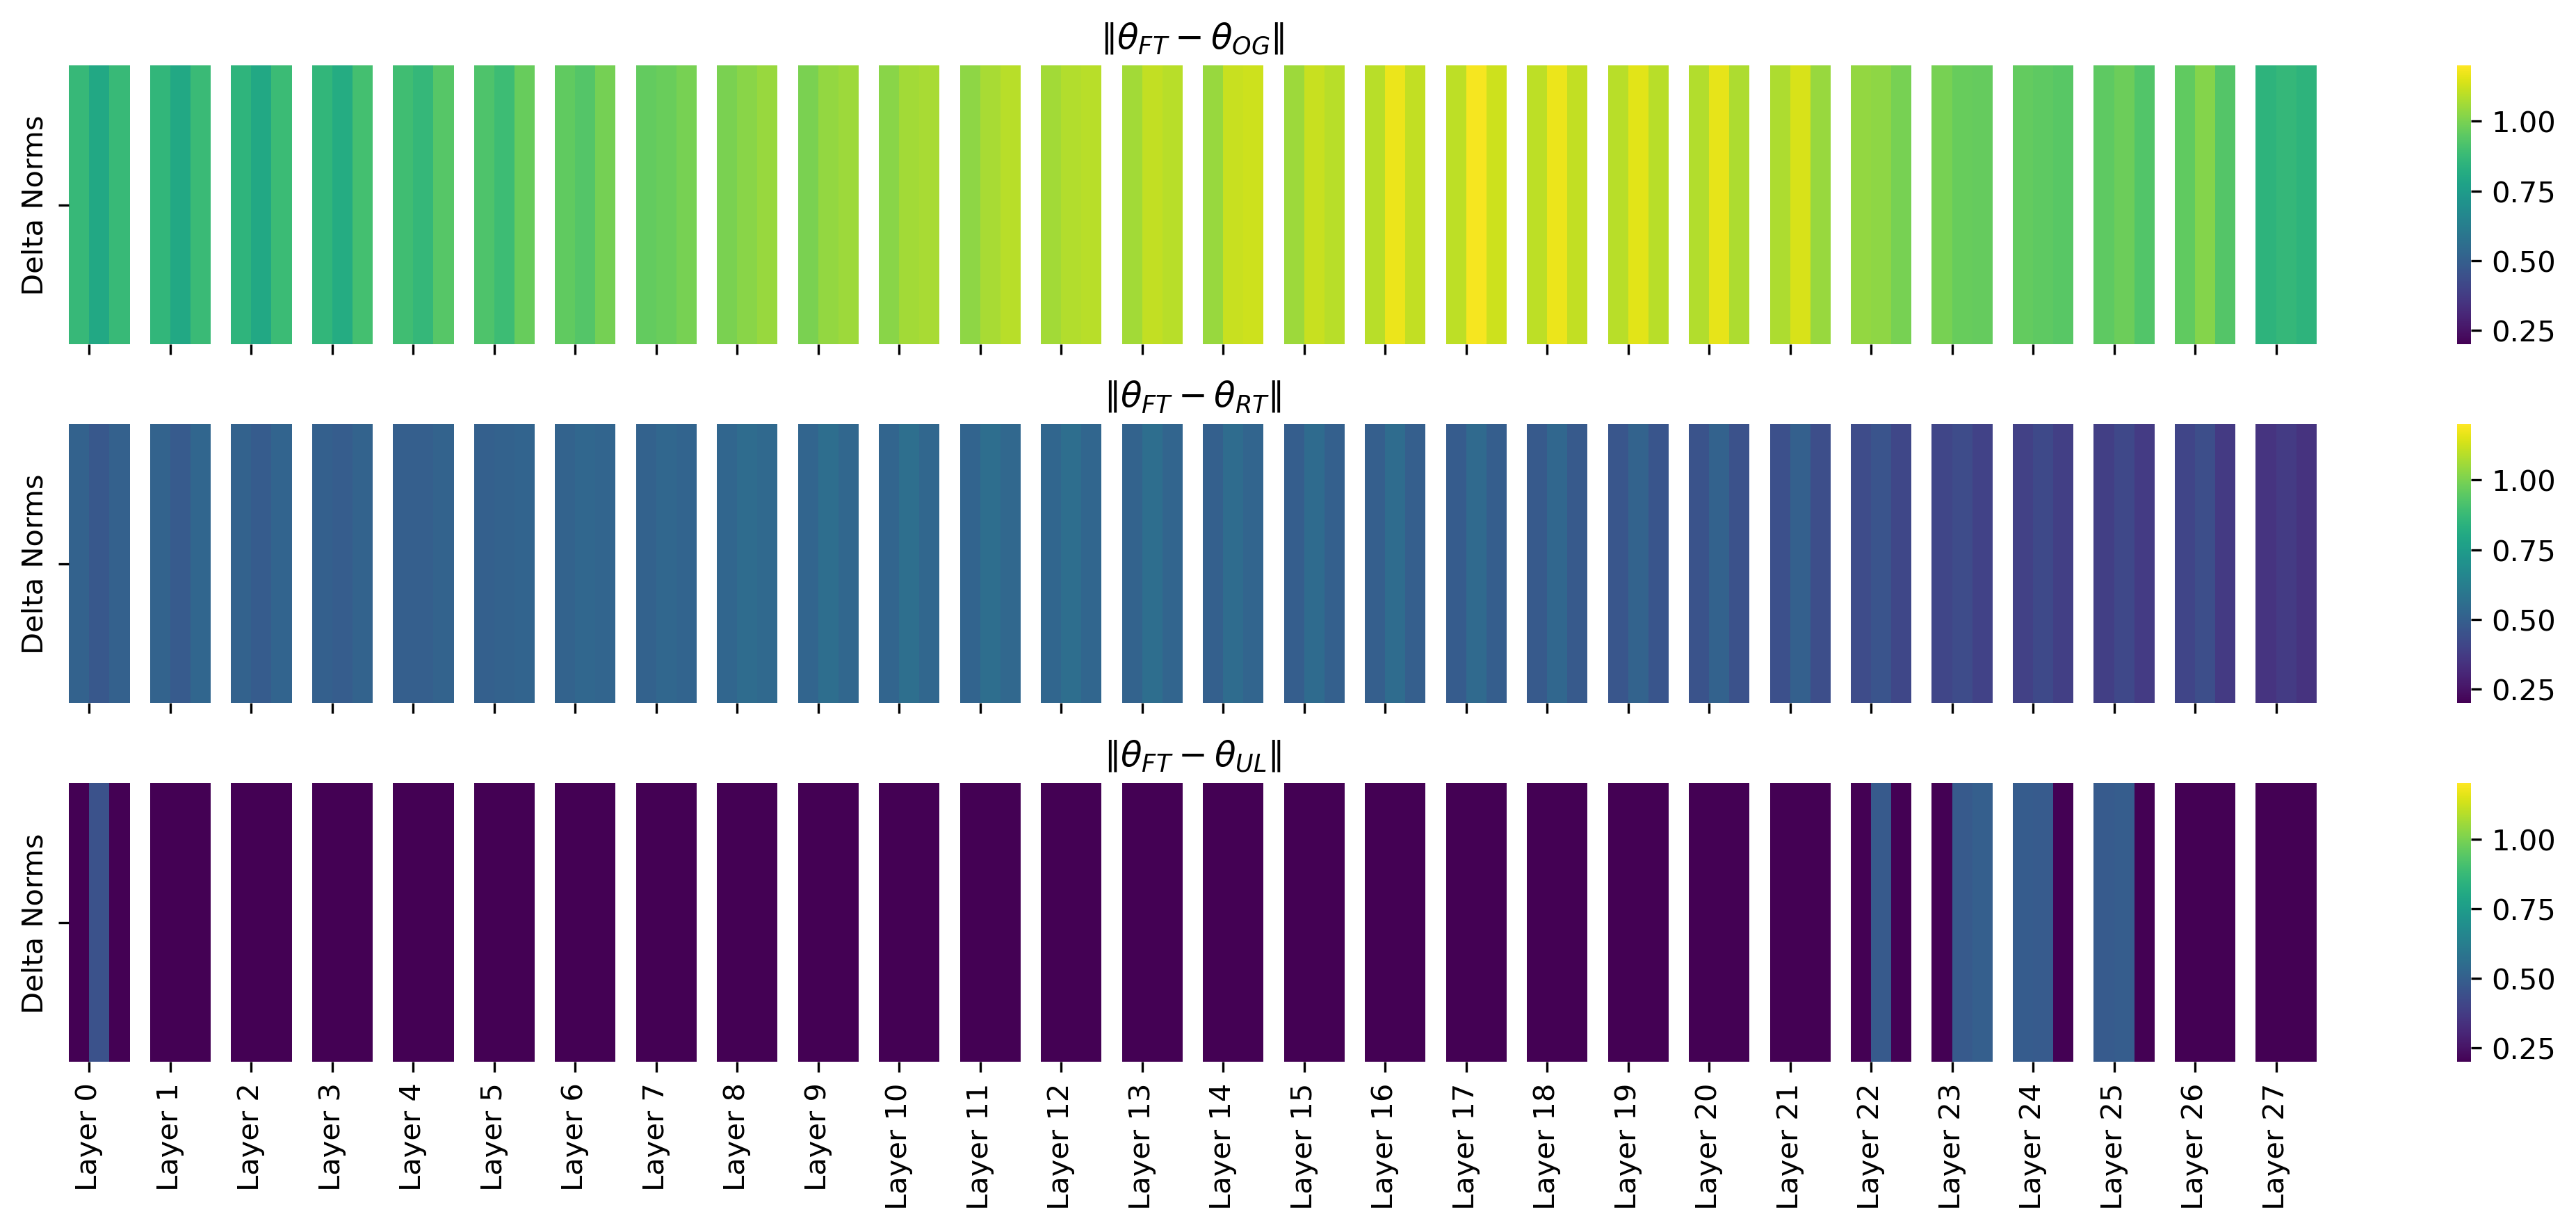

In [228]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
    models=[
        "models/qwen2-1.5b",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_retain99_seed42/checkpoint-1237",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_so-influence_k0.1+0_3e-05_forget01_8_to-examine/checkpoint-18",
        ],
    titles=[r"$\left\Vert\theta_{FT} - \theta_{OG}\right\Vert$", r"$\left\Vert\theta_{FT} - \theta_{RT}\right\Vert$", r"$\left\Vert\theta_{FT} - \theta_{UL}\right\Vert$"],
    in_scope=[
        # "embed",
        "mlp",
        # "attn",
        # "norm",
    ],
    # out_scope=None,
    vmin=0.2, vmax=1.2,
)

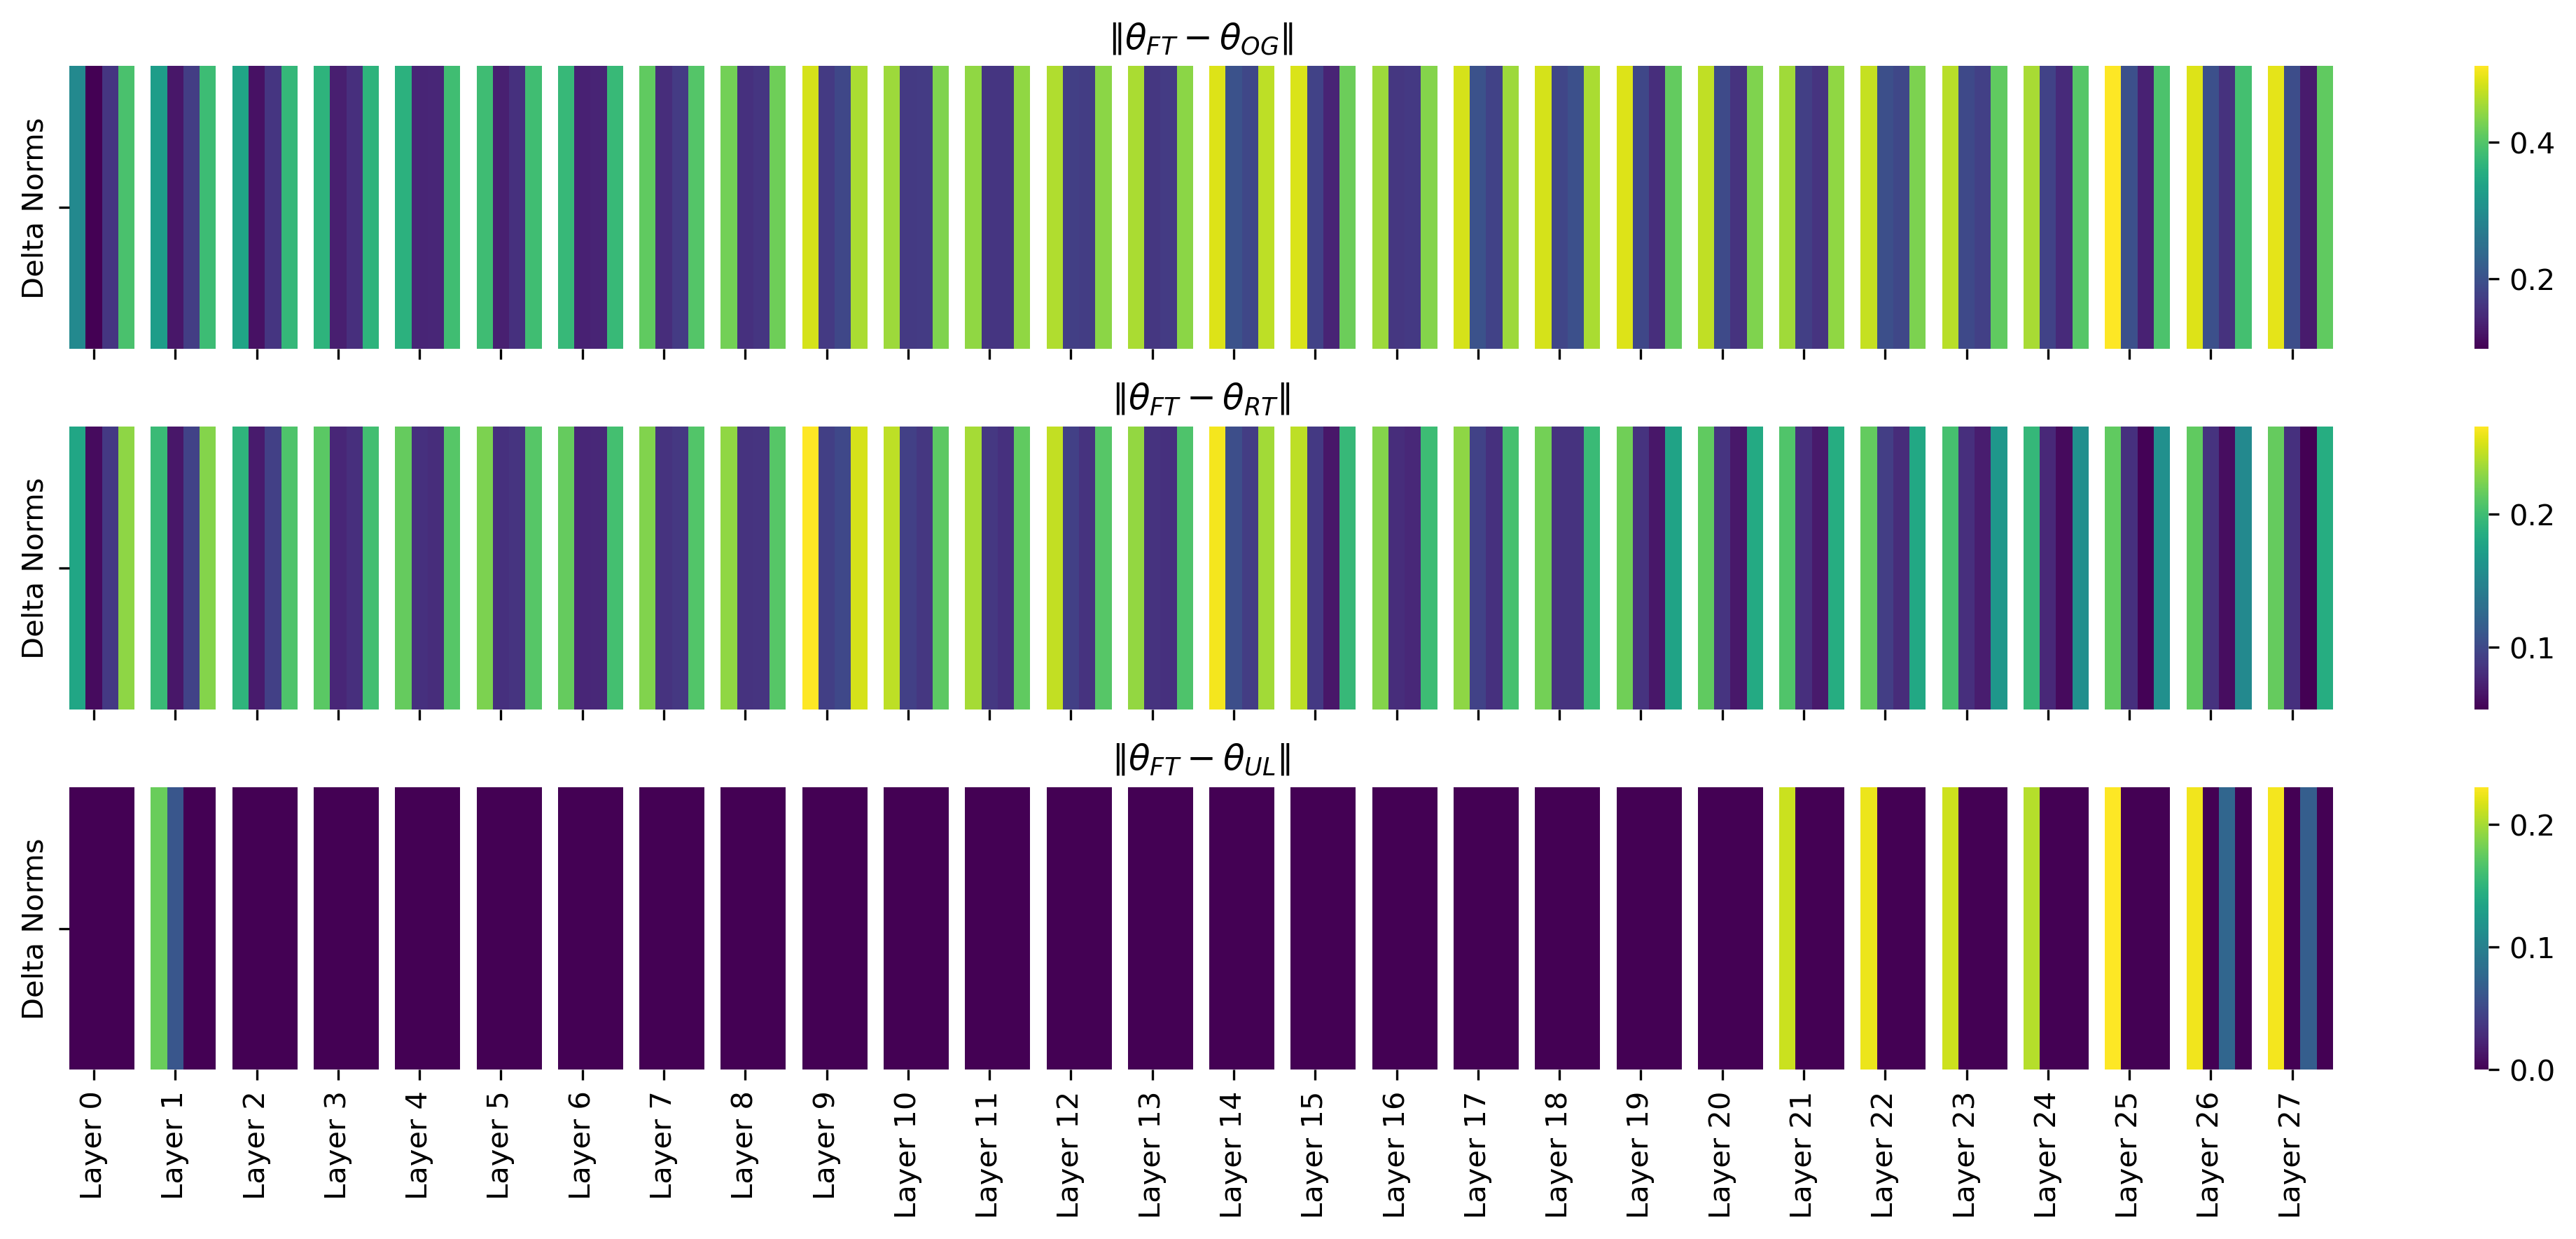

In [225]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
    models=[
        "models/qwen2-1.5b",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_retain99_seed42/checkpoint-1237",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_so-influence_k0.1+0_3e-05_forget01_8_to-examine/checkpoint-18",
        ],
    titles=[r"$\left\Vert\theta_{FT} - \theta_{OG}\right\Vert$", r"$\left\Vert\theta_{FT} - \theta_{RT}\right\Vert$", r"$\left\Vert\theta_{FT} - \theta_{UL}\right\Vert$"],
    in_scope=[
        # "embed",
        # "mlp",
        "attn",
        # "norm",
    ],
    # out_scope=None,
)

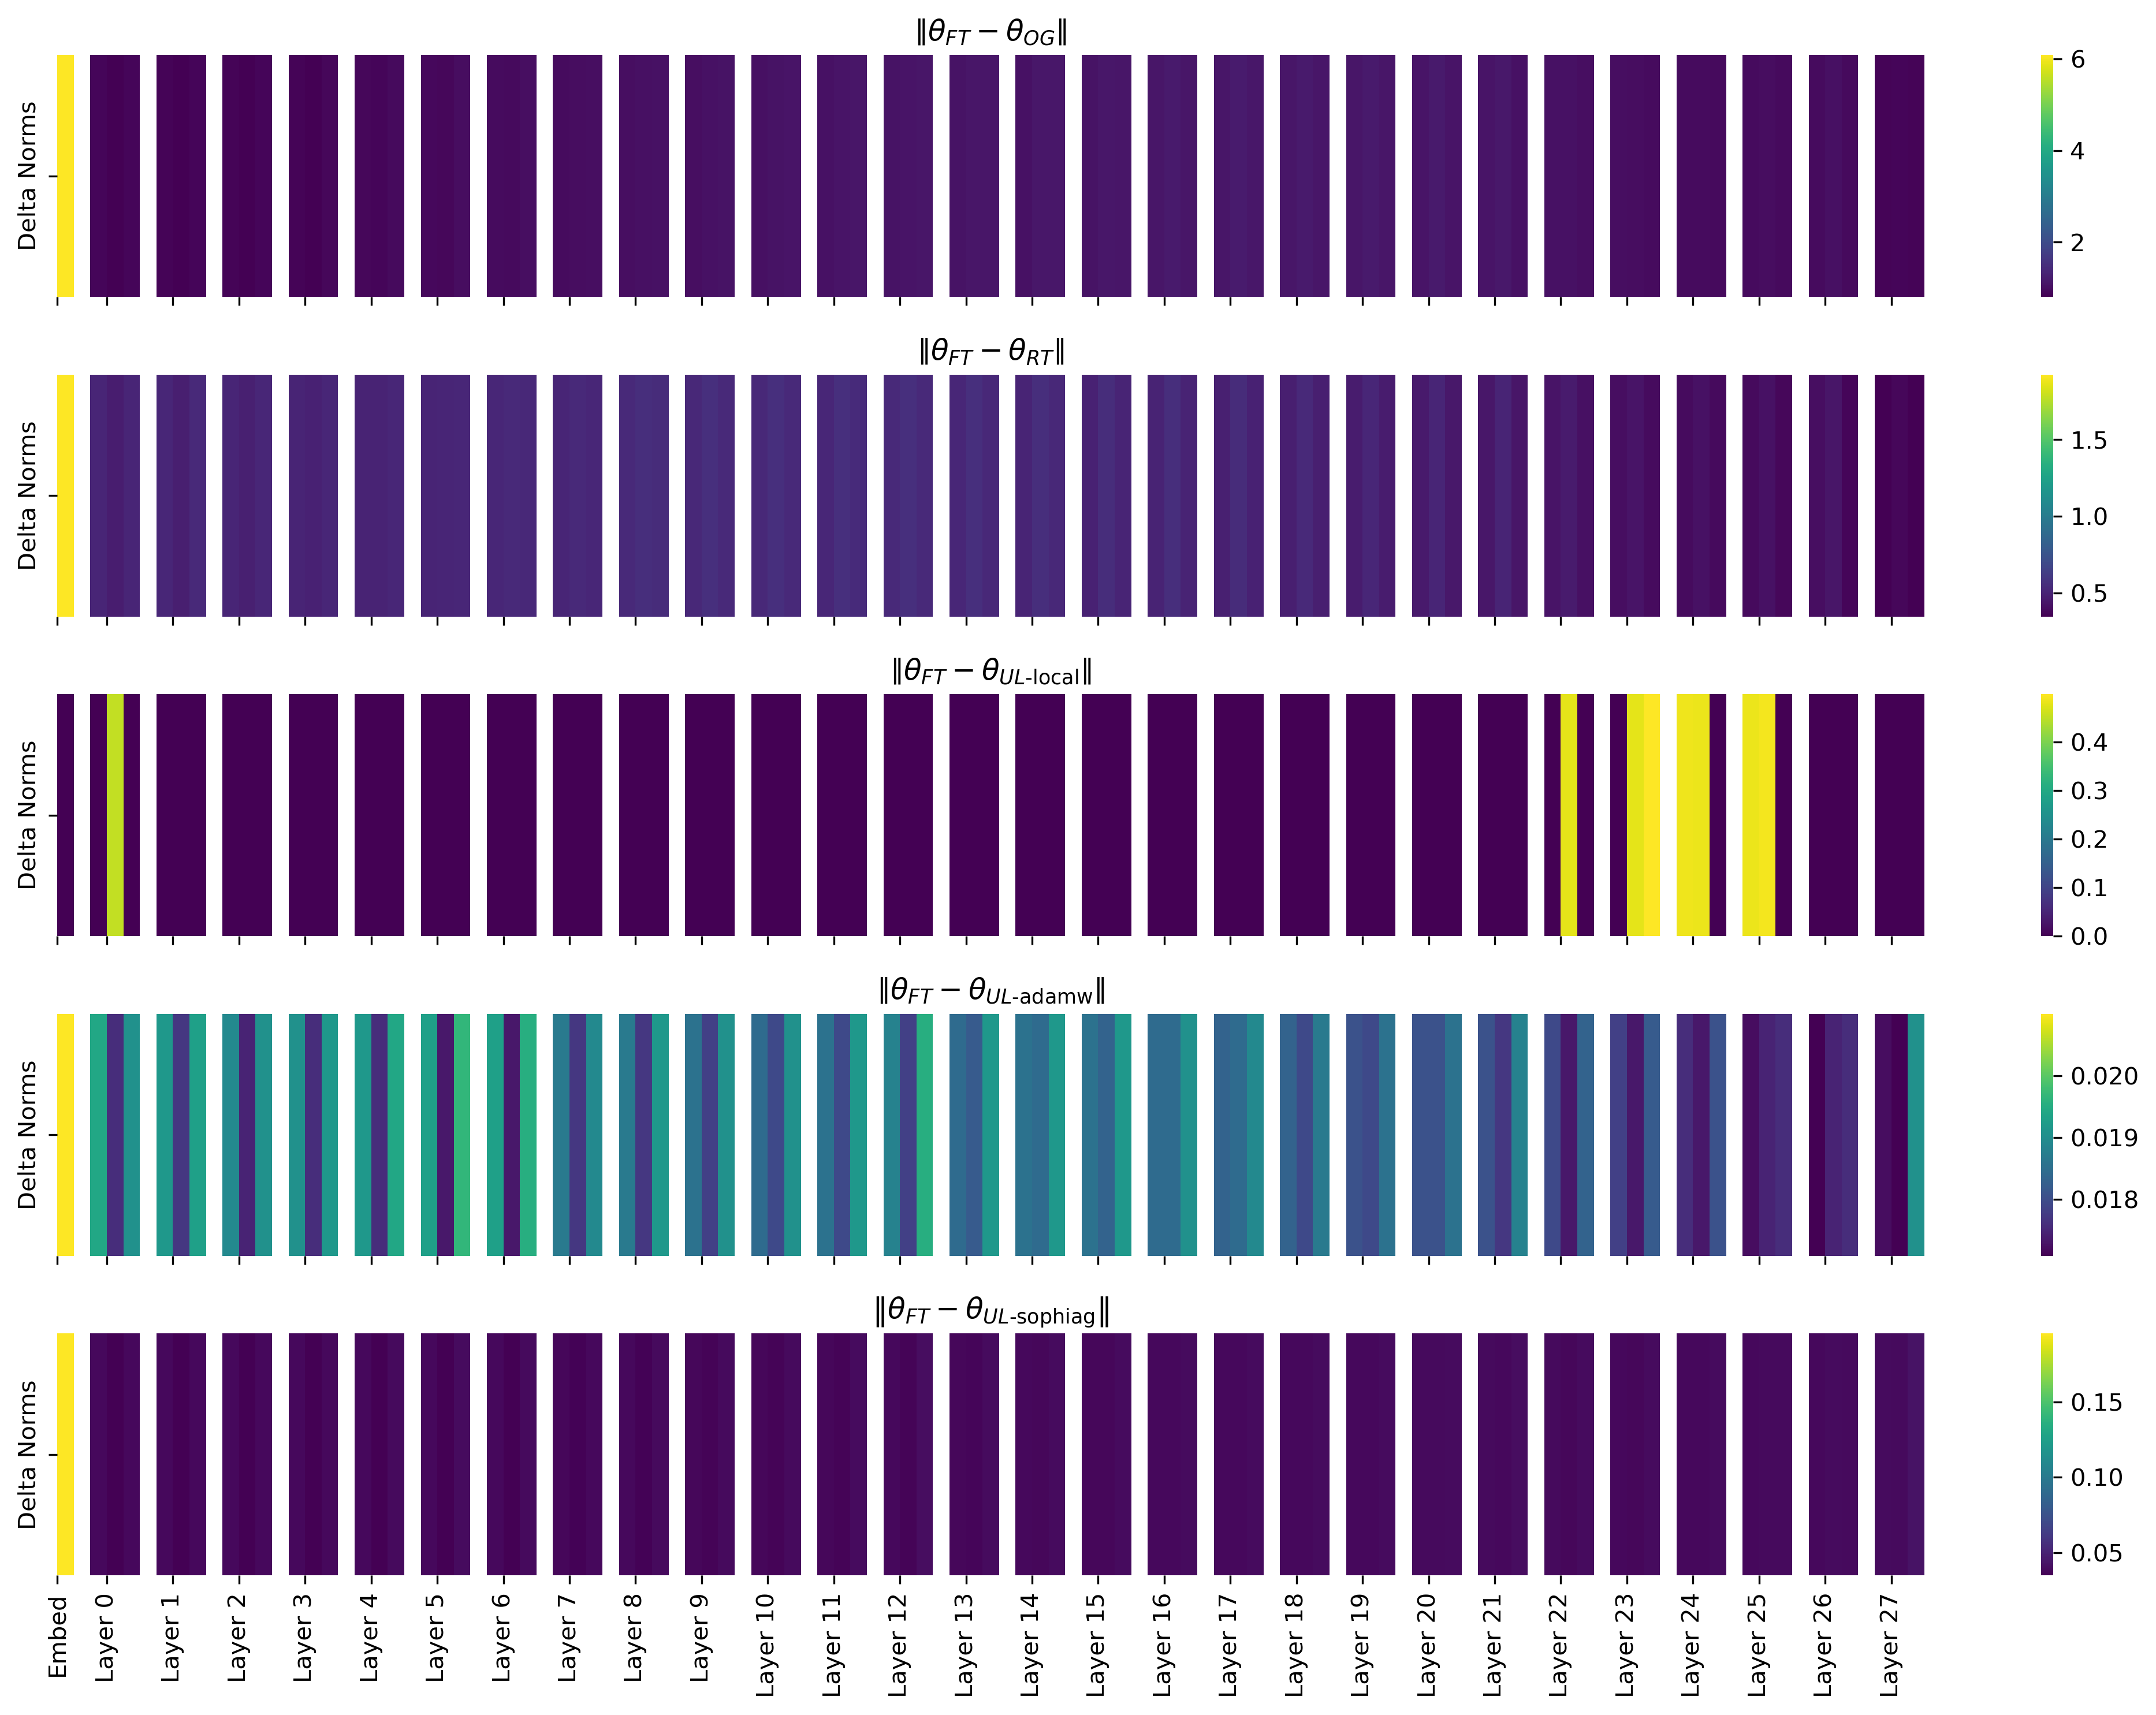

In [241]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
    models=[
        "models/qwen2-1.5b",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_retain99_seed42/checkpoint-1237",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_so-influence_k0.1+0_3e-05_forget01_8_to-examine/checkpoint-18",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/adamw_grad-ascent_none_k1_5e-06_forget01_8/checkpoint-20",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_none_k1_5e-06_forget01_8/checkpoint-20",
        ],
    titles=[
        r"$\left\Vert\theta_{FT} - \theta_{OG}\right\Vert$",
        r"$\left\Vert\theta_{FT} - \theta_{RT}\right\Vert$",
        r"$\left\Vert\theta_{FT} - \theta_{UL\text{-local}}\right\Vert$",
        r"$\left\Vert\theta_{FT} - \theta_{UL\text{-adamw}}\right\Vert$",
        r"$\left\Vert\theta_{FT} - \theta_{UL\text{-sophiag}}\right\Vert$",
    ],
    in_scope=[
        "embed",
        "mlp",
        # "attn",
        # "norm",
    ],
    # out_scope=None,
)

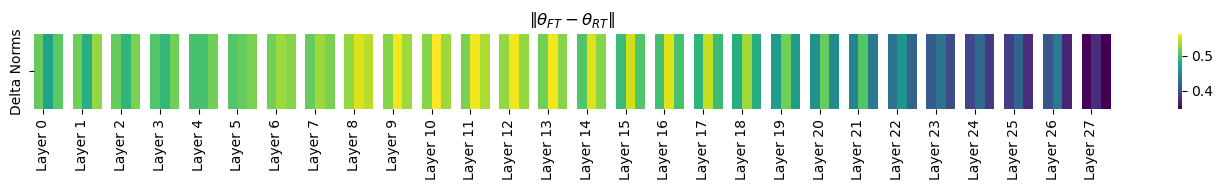

In [66]:
plot_layer_comparisons(
    base_model="models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
    models=[
        # "models/qwen2-1.5b",
        "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_retain99_seed42/checkpoint-1237",
        # "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_so-influence_k0.1+0_3e-05_forget01_8_to-examine/checkpoint-18",
        # "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/adamw_grad-ascent_none_k1_5e-06_forget01_8/checkpoint-20",
        # "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_none_k1_5e-06_forget01_8/checkpoint-20",
        ],
    titles=[
        # r"$\left\Vert\theta_{FT} - \theta_{OG}\right\Vert$",
        r"$\left\Vert\theta_{FT} - \theta_{RT}\right\Vert$",
        # r"$\left\Vert\theta_{FT} - \theta_{UL\text{-local}}\right\Vert$",
        # r"$\left\Vert\theta_{FT} - \theta_{UL\text{-adamw}}\right\Vert$",
        # r"$\left\Vert\theta_{FT} - \theta_{UL\text{-sophiag}}\right\Vert$",
    ],
    in_scope=[
        # "embed",
        "mlp",
        # "attn",
        # "norm",
    ],
    # out_scope=None,
    # vmin=0.035, vmax=0.045,
    # save_name="figures/PD_qwen_tofu_rt_mlp.svg"
)

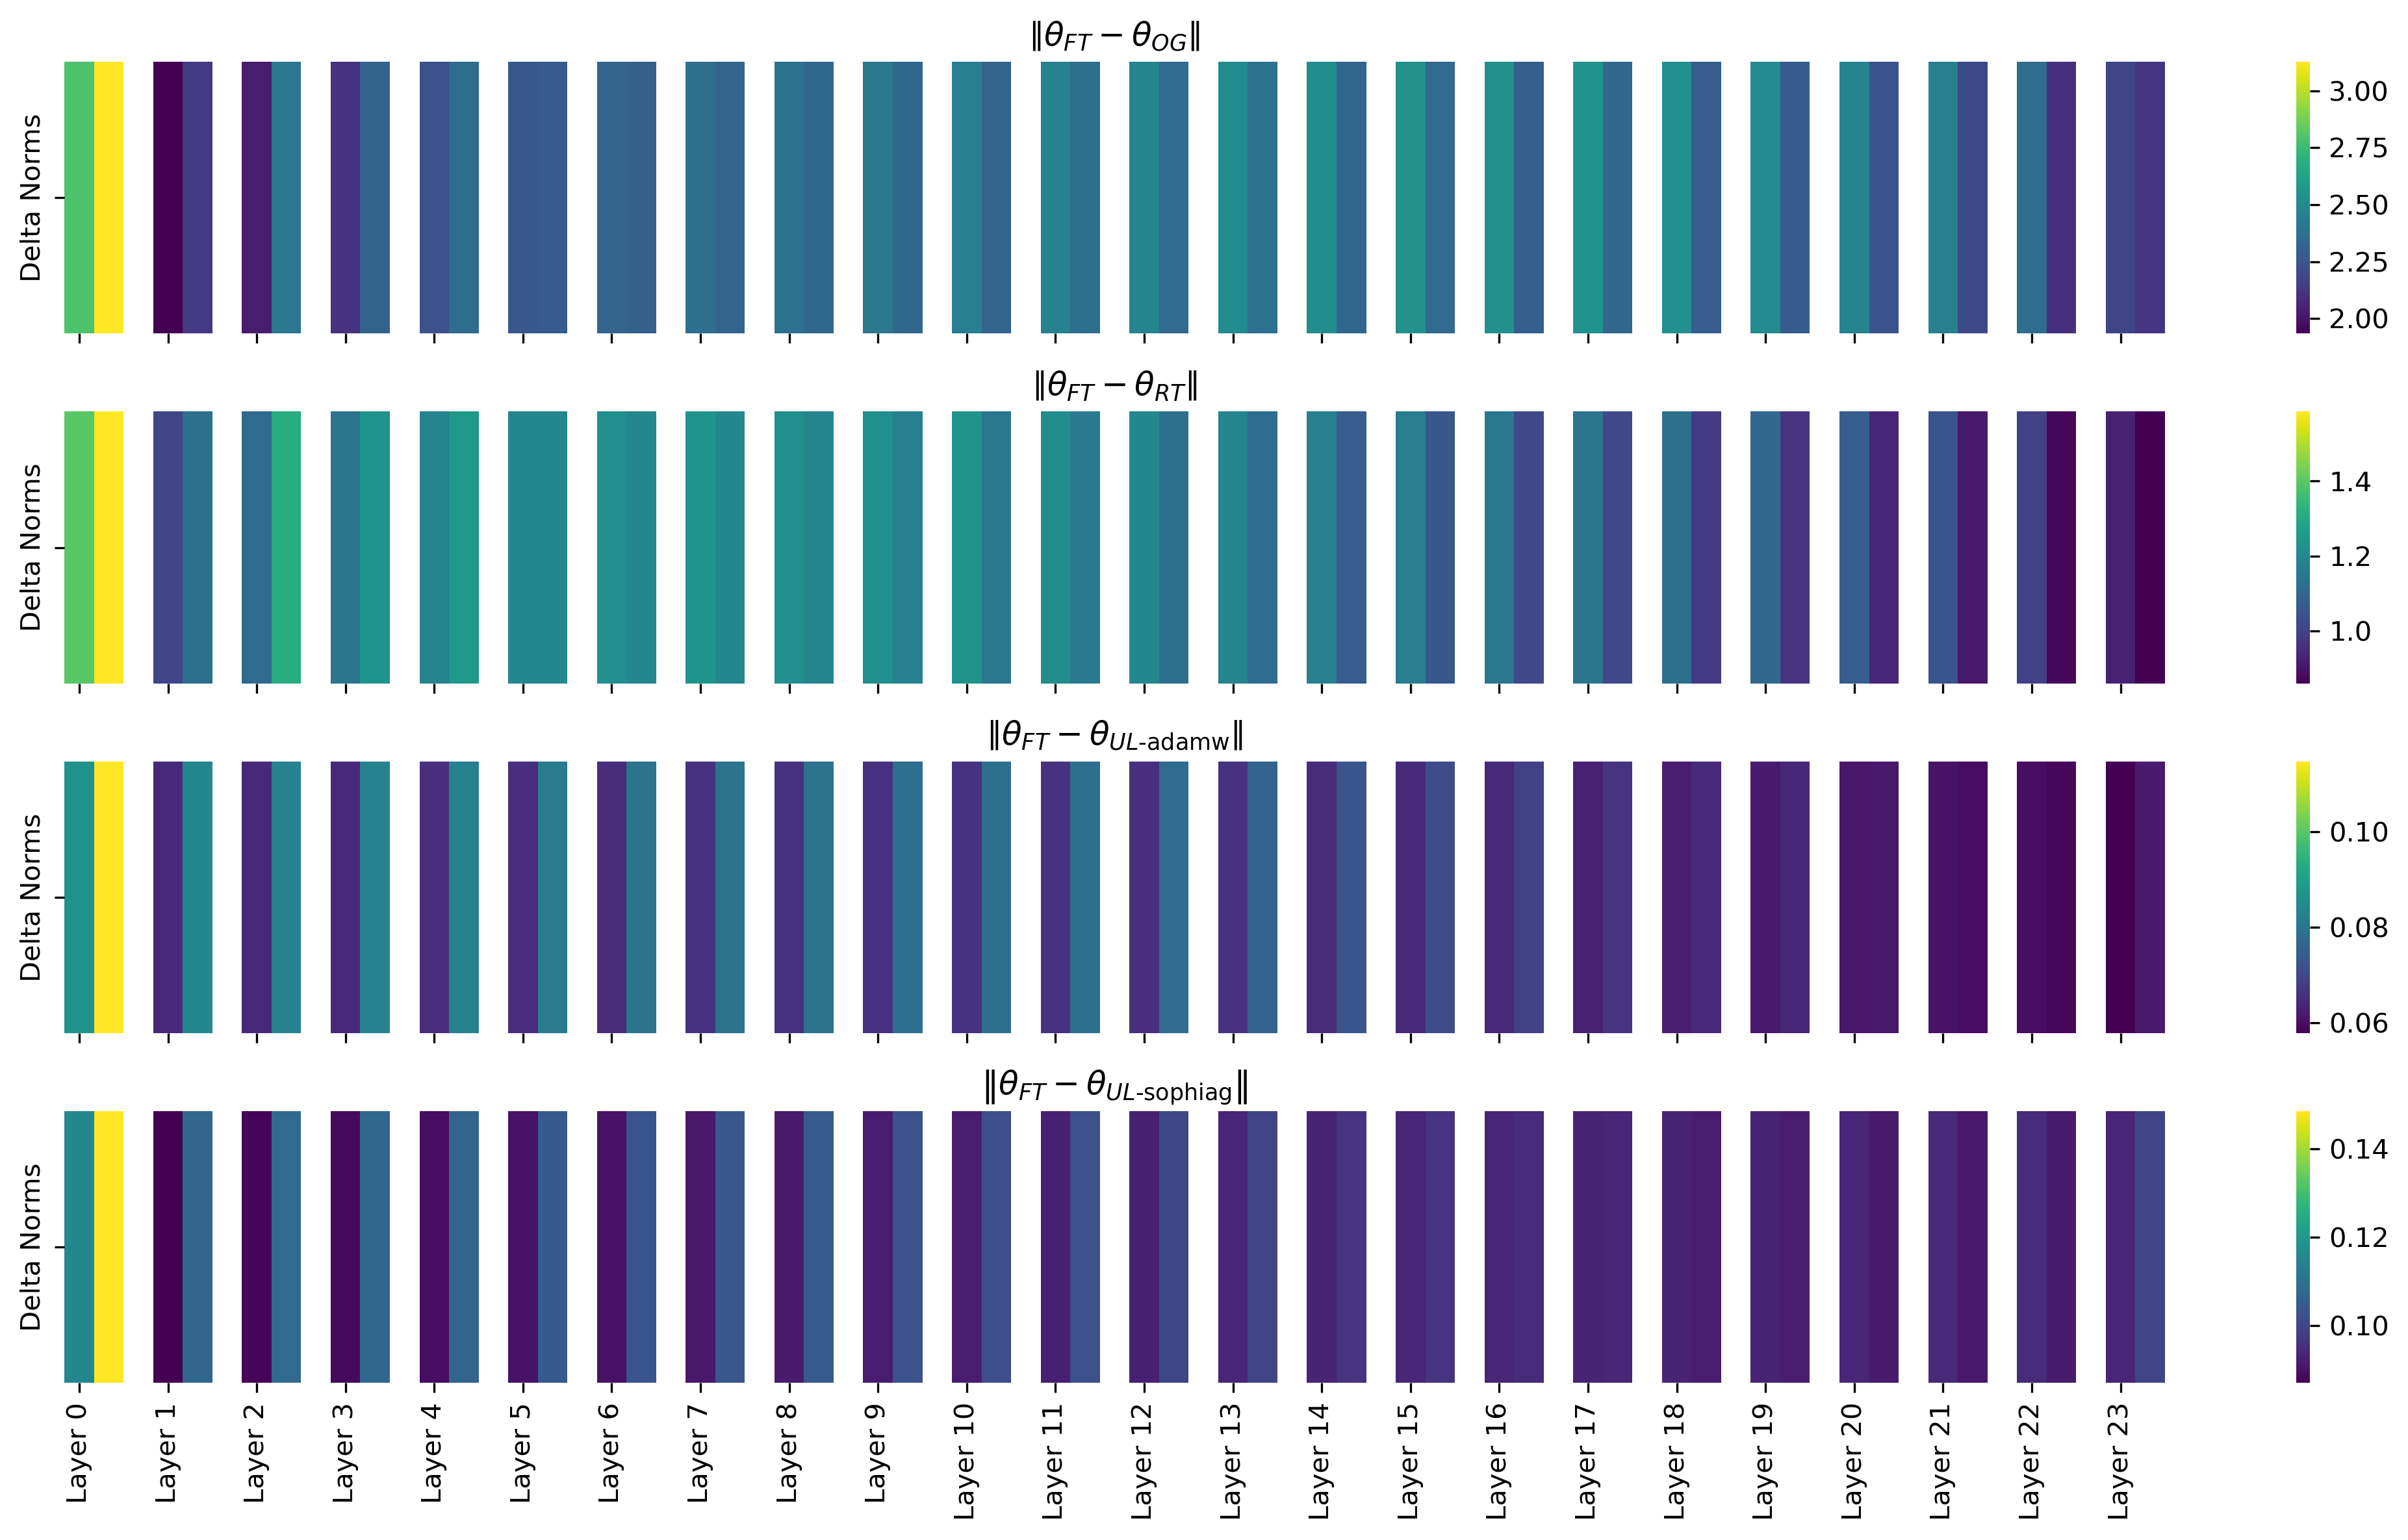

In [4]:
plot_layer_comparisons(
    base_model="models/phi_ft_tofu-4000_noLORA_epochs10_lr5e-05_wd0.01_full_seed42/checkpoint-1250",
    models=[
        "models/phi",
        "models/phi_ft_tofu-4000_noLORA_epochs10_lr5e-05_wd0.01_retain99_seed42/checkpoint-1237",
        "models/phi_ft_tofu-4000_noLORA_epochs10_lr5e-05_wd0.01_full_seed42/checkpoint-1250/adamw_grad-ascent_none_k1_1e-05_forget01_12/checkpoint-30",
        "models/phi_ft_tofu-4000_noLORA_epochs10_lr5e-05_wd0.01_full_seed42/checkpoint-1250/sophiag_grad-ascent_none_k1_1e-05_forget01_8/checkpoint-20",
        ],
    titles=[
        r"$\left\Vert\theta_{FT} - \theta_{OG}\right\Vert$",
        r"$\left\Vert\theta_{FT} - \theta_{RT}\right\Vert$",
        r"$\left\Vert\theta_{FT} - \theta_{UL\text{-adamw}}\right\Vert$",
        r"$\left\Vert\theta_{FT} - \theta_{UL\text{-sophiag}}\right\Vert$",
    ],
    in_scope=[
        # "embed",
        "mlp",
        # "attn",
        # "norm",
        # "lm_head",
    ],
    # out_scope=None,
    # vmin=0.05, vmax=0.15,
)

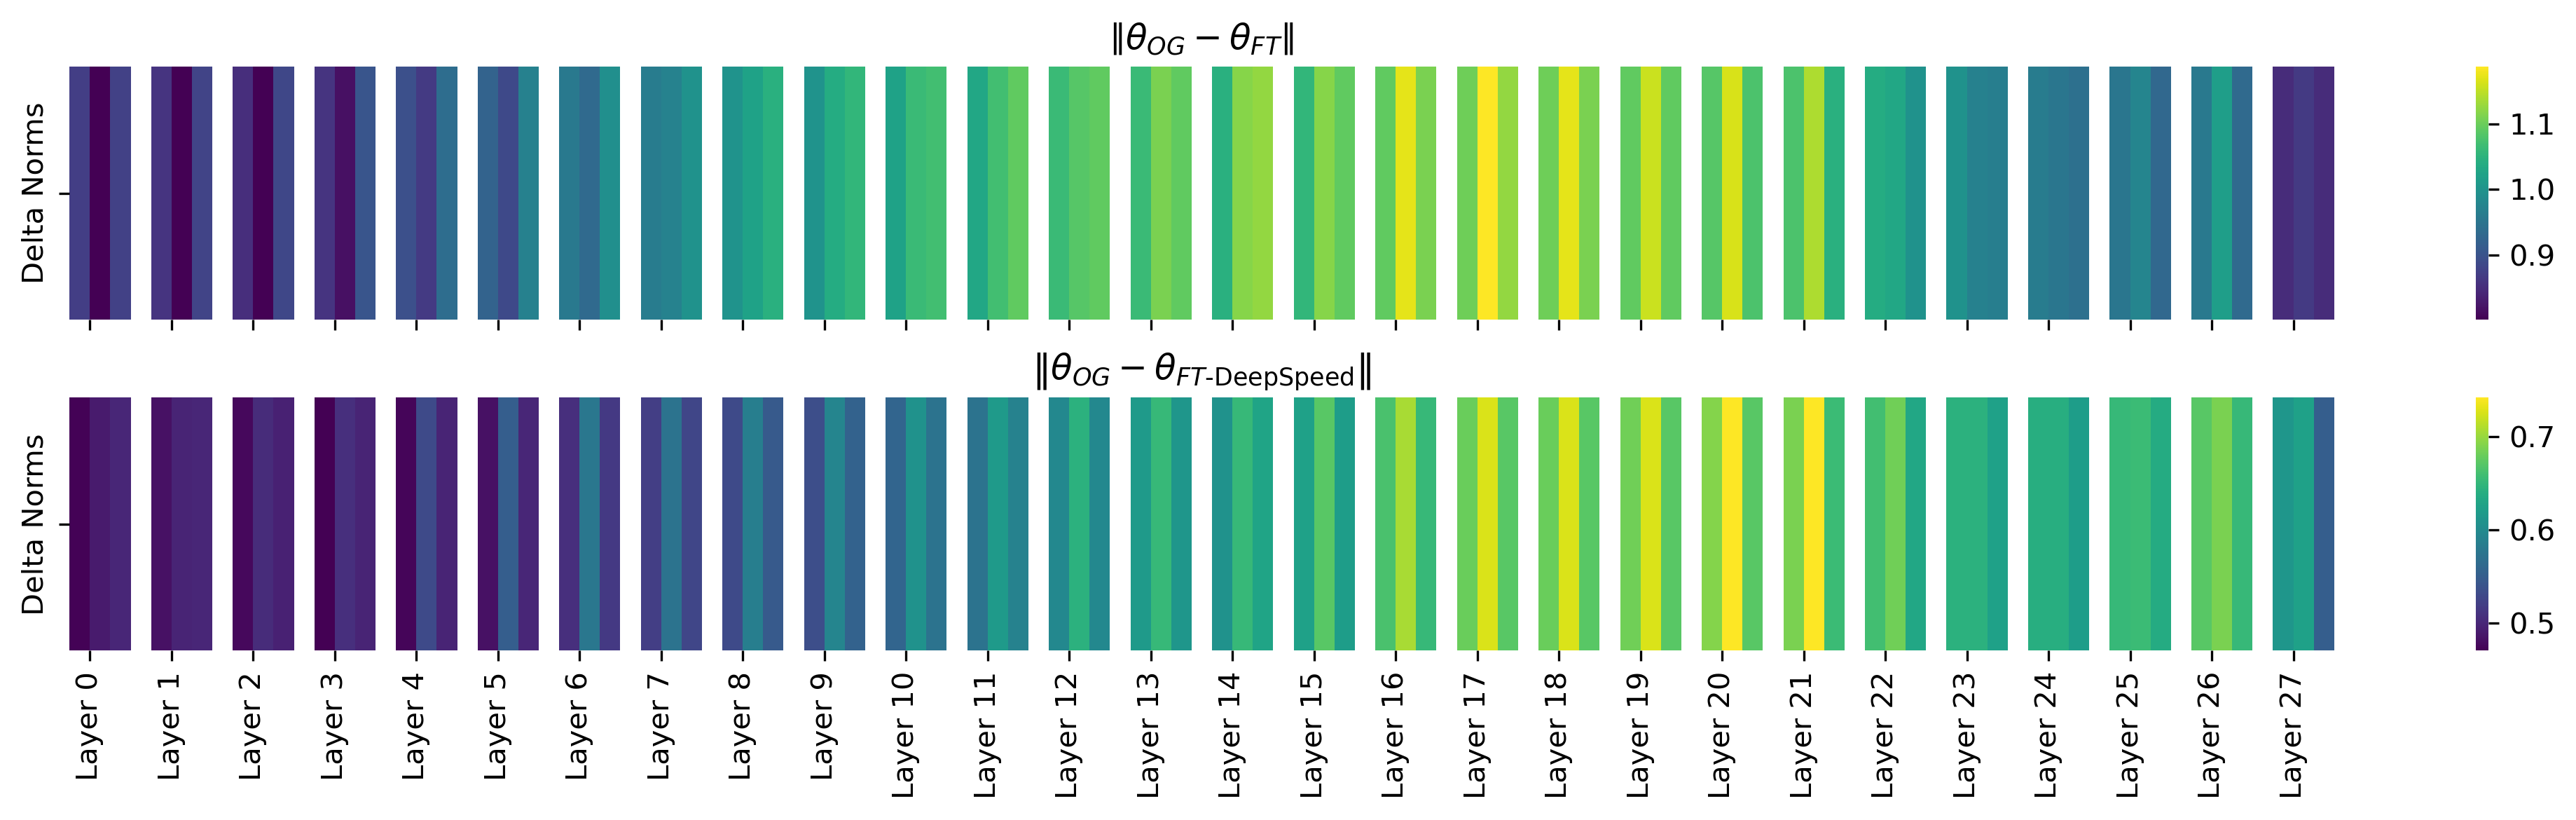

In [86]:

plot_layer_comparisons(
    base_model="models/qwen2-1.5b",
    models=[
        "models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
        "models/qwen2-1.5_ft_DS_1e-05_full"
        ],
    titles=[
        r"$\left\Vert\theta_{OG} - \theta_{FT}\right\Vert$",
        r"$\left\Vert\theta_{OG} - \theta_{FT\text{-DeepSpeed}}\right\Vert$",
    ],
    in_scope=[
        # "embed",
        "mlp",
        # "attn",
        # "norm",
    ],
    # out_scope=None,
    # vmin=0.035, vmax=0.045,
)

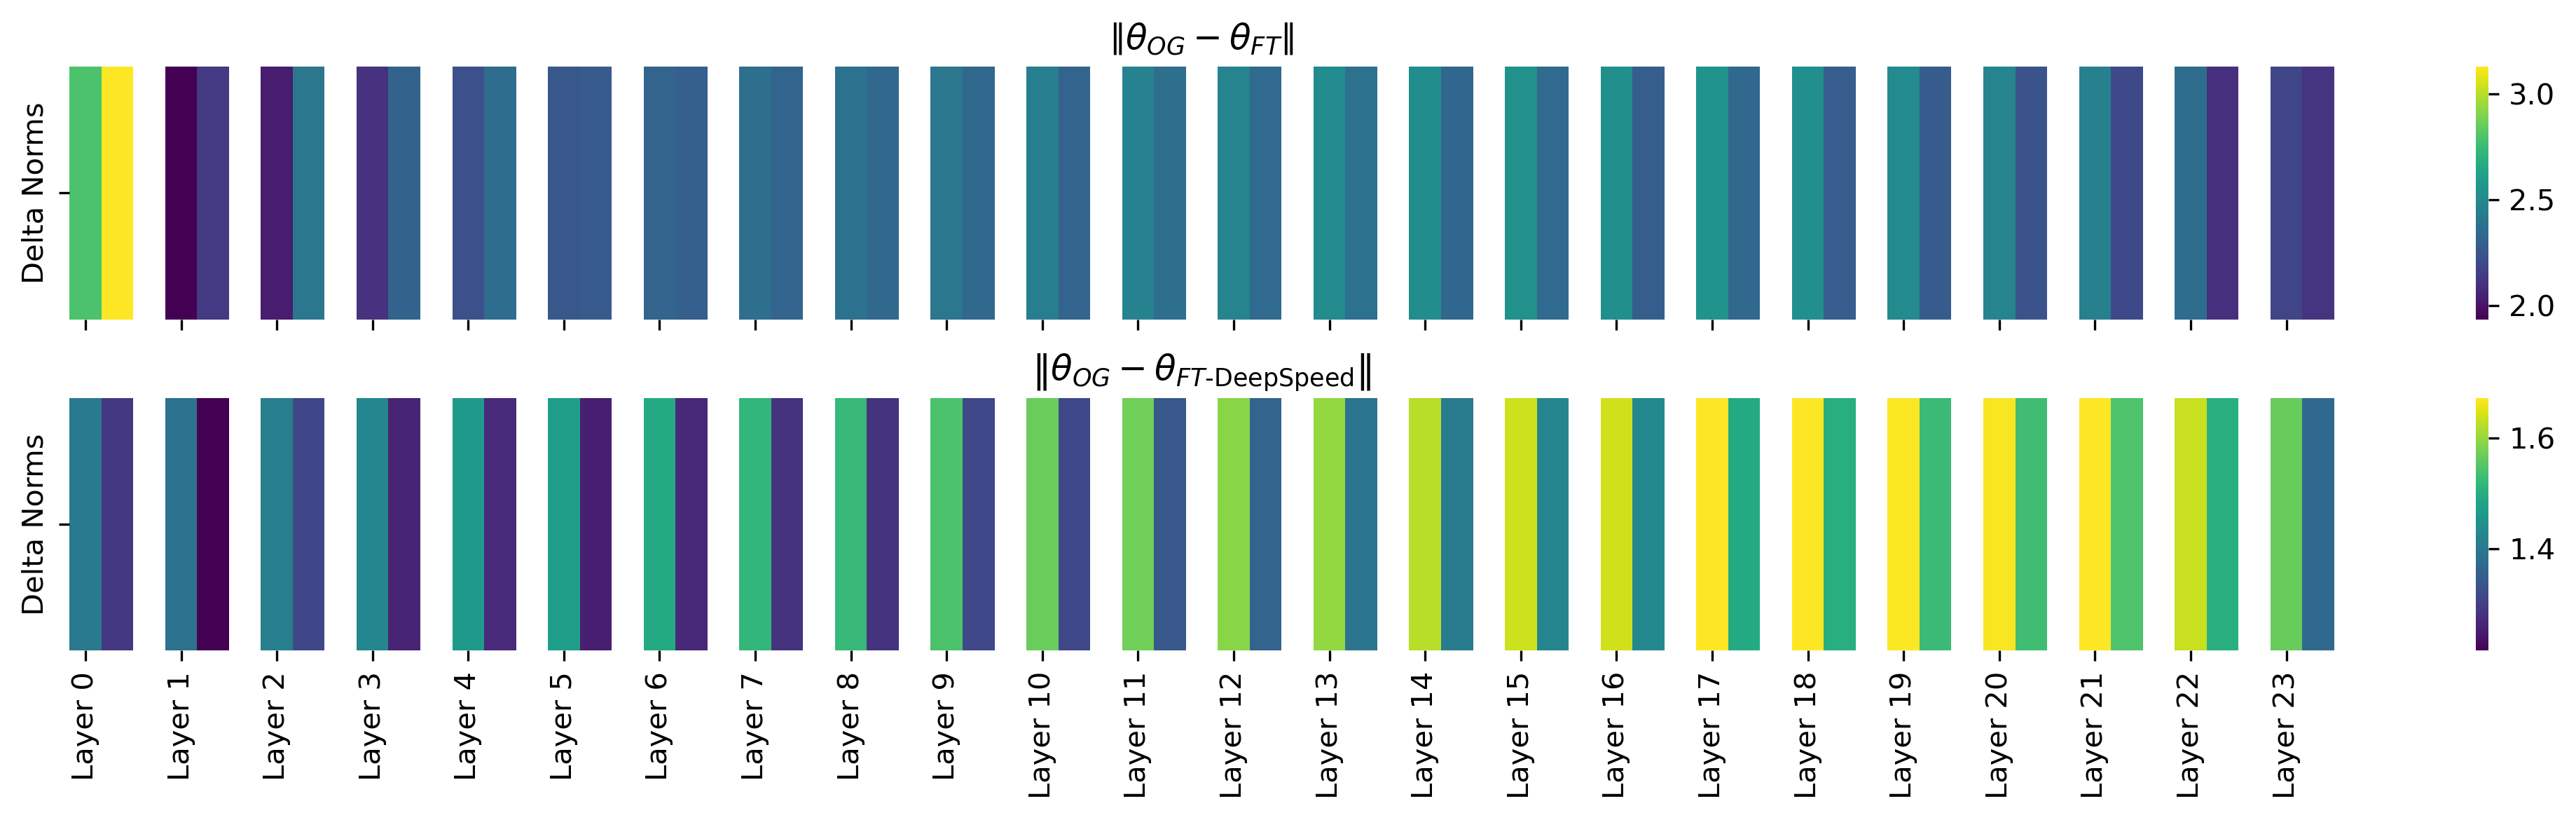

In [12]:
plot_layer_comparisons(
    base_model="models/phi",
    models=[
        "models/phi_ft_tofu-4000_noLORA_epochs10_lr5e-05_wd0.01_full_seed42/checkpoint-1250",
        "models/phi_ft_tofu_locuslab",
        ],
    titles=[
        r"$\left\Vert\theta_{OG} - \theta_{FT}\right\Vert$",
        r"$\left\Vert\theta_{OG} - \theta_{FT\text{-DeepSpeed}}\right\Vert$",
    ],
    in_scope=[
        # "embed",
        "mlp",
        # "attn",
        # "norm",
        # "lm_head",
    ],
    # out_scope=None,
    # vmin=0.5, vmax=1.5,
    # save_name="figures/PD_phi_tofu_mlp_DS_noDS.svg"
)

## Sequential layer heatmaps

In [188]:
def plot_all_layer_heatmap(params1, params2, vminmax=(None, None), in_scope=None, out_scope=['bias']):
    params1 = get_params_safe(params1)
    params2 = get_params_safe(params2)
    delta = get_param_diff_norm(params1, params2)
    delta = list(delta.items())

    # delta = [(k, v) for k, v in delta if "mlp." in k or "attn." in k]
    # delta = [(k, v) for k, v in delta if ".weight" in k]

    if in_scope:
        delta = [(k, v) for k, v in delta if any([scope in k for scope in in_scope])]

    if out_scope:
        delta = [(k, v) for k, v in delta if all([scope not in k for scope in out_scope])]

    delta_plot = delta
    # delta_plot = [(k, v) for k, v in delta_plot if "mlp." in k or "attn." in k]
    # delta_plot = [(k, v) for k, v in delta_plot if ".weight" in k]

    # Extract parameter names and delta norms
    param_names = [item[0] for item in delta_plot]
    delta_norms = [item[1] for item in delta_plot]

    # Plot using seaborn
    plt.figure(figsize=(16, 5))
    sns.heatmap(np.array([delta_norms]), annot=False, cmap='viridis', cbar=True, yticklabels=["Delta Norms"], vmin=vminmax[0], vmax=vminmax[1])

    # Set title and x-axis labels
    # plt.xticks(ticks=np.arange(len(param_names)), labels=param_names, rotation=90)
    plt.title("Heatmap of Delta Norms for Model Parameters")
    plt.show()

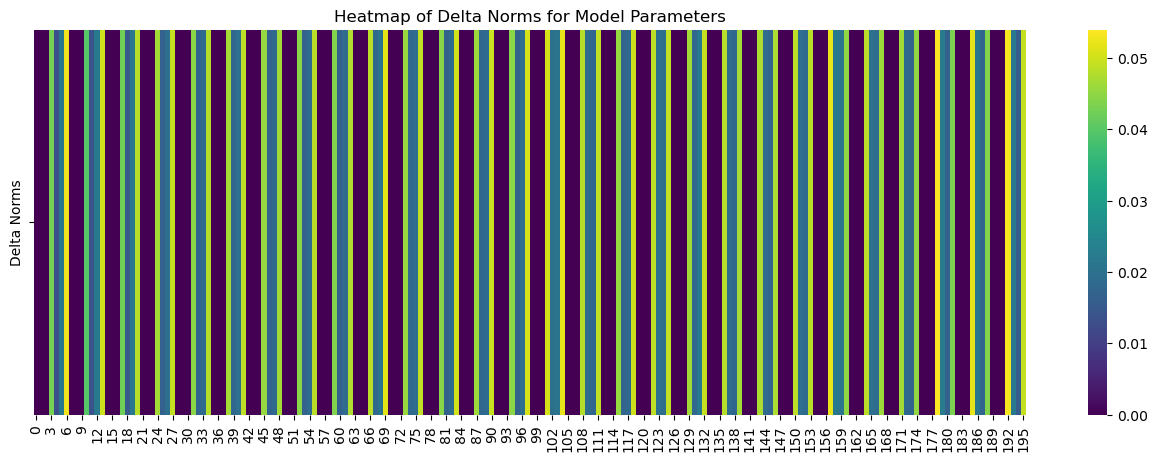

In [192]:
plot_all_layer_heatmap(
    "models/qwen2-1.5b_ft_tofu-4000_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250",
    "models/qwen2-1.5b_ft_tofu_noLORA_epochs10_lr2.5e-05_wd0.01_full_seed42/checkpoint-1250/attn_only/sophiag_grad-ascent_none_k1_1e-05_forget01_8/checkpoint-20",
    # vminmax=(0.2, 0.2),
    in_scope=[
        # "embed",
        "mlp",
        "attn",
        # "norm",
    ],
)